Significance:

$$Z = \frac{S}{\sqrt{S+B}}$$

In [1]:
import awkward as ak
import pandas as pd
import numpy as np
import vector
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents import NanoAODSchema, DelphesSchema
import mplhep as hep
import matplotlib.pyplot as plt
import seaborn as sns
import DM_HEP_AN as dm
from math import pi
from funcs import *
hep.style.use("CMS")
#%matplotlib inline
plt.ioff()

In [2]:
# Signal
nMassPoints = 2
cases = ["gSq_only","gSg1_only", "gSg2_only_y0y0", "gSg_only"]
data = {}
for i in cases:
    csvFile = [f"./sim_outputs/csv/DM_{i}_{j}.csv" for j in range(nMassPoints)]
    data[i] = [pd.read_csv(j) for j in csvFile]

In [3]:
print("Número de Eventos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])

Número de Eventos:  [[100000, 100000], [100000, 100000], [100000, 100000], [100000, 100000]]


In [4]:
data['gSq_only'][1]

,Unnamed: 0,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,jet_eta3,jet_phi0,...,jet_tautag1,jet_tautag2,jet_tautag3,missinget_met,missinget_phi,Delta_phi,Delta_rapidity,Inv_mass,Rapidity_prod,Hadronic_energy
0,0,843.61100,769.96410,64.070175,28.701233,1.761326,0.246164,-1.682540,1.236294,-0.495366,...,0.0,0.0,0.0,21.809408,-1.088880,3.085388,1.515163,3337.800428,0.433574,1706.346508
1,1,1041.50420,843.74040,261.274000,182.849850,0.183902,0.514633,0.471820,-1.019326,2.119979,...,0.0,0.0,0.0,75.026570,-1.180947,3.119247,0.330732,4250.887240,0.094642,2329.368450
2,2,1009.92940,901.72330,369.370700,82.121330,0.340244,-0.233670,0.700135,-2.374313,-2.947577,...,0.0,0.0,0.0,7.409536,1.953242,2.864853,0.573915,3728.462258,-0.079505,2363.144730
3,3,877.97540,658.37933,205.111190,63.326767,-0.578712,0.894802,2.138434,-1.949215,2.209744,...,0.0,0.0,0.0,18.451687,1.971144,2.951206,1.473514,2903.831584,-0.517833,1804.792687
4,4,1042.62430,976.43080,105.126390,39.665718,-0.204602,-0.204091,-0.552801,-1.651142,2.496748,...,0.0,0.0,0.0,112.703680,2.431132,3.063362,0.000512,4449.395671,0.041758,2163.847208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,49995,1013.42740,795.69293,473.857640,79.261580,-0.717826,-1.752220,-0.716235,1.177053,-0.721572,...,0.0,0.0,0.0,40.344994,-0.440011,3.012814,1.034394,3726.894241,1.257789,2362.239550
99996,49996,946.15594,869.65600,250.851940,102.127540,-0.235768,0.387236,-0.989526,0.760140,-0.173081,...,0.0,0.0,0.0,27.080442,2.412556,2.751452,0.623004,3311.641363,-0.091298,2168.791420
99997,49997,1003.50010,802.78500,201.446900,64.700325,-0.313275,0.687755,-1.523021,-1.967147,2.397171,...,0.0,0.0,0.0,123.030304,0.276830,2.802356,1.001030,3292.369858,-0.215457,2072.432325
99998,49998,467.68225,397.52505,57.085660,52.438076,-1.113589,1.833702,-1.979064,-1.983583,-2.322247,...,0.0,0.0,0.0,14.646034,-2.864364,2.705787,2.947291,870.281343,-2.041990,974.731036


In [5]:
# Background
csvFile = "./background/ZpJets.csv"
data_ZpJ = pd.read_csv(csvFile)
csvFile = "./background/WpJets.csv"
data_WpJ = pd.read_csv(csvFile)

Cross-section

In [6]:
CSs = pd.read_csv('signalCS.csv').to_dict()

In [7]:
CSs.pop('Unnamed: 0')

{0: 0, 1: 1}

In [8]:
CSs

{'gSq_only': {0: 0.170535, 1: 3.6982e-05},
 'errorgSq_only': {0: 0.000287, 1: 6.53e-08},
 'gSg1_only': {0: 210.265, 1: 6.9670000000000005},
 'errorgSg1_only': {0: 0.269, 1: 0.0112},
 'gSg2_only_y0y0': {0: 0.00081182, 1: 0.00016269},
 'errorgSg2_only_y0y0': {0: 9.375e-07, 1: 2.745e-07},
 'gSg_only': {0: 210.355, 1: 6.9663},
 'errorgSg_only': {0: 0.255, 1: 0.0113499999999999}}

In [9]:
# fictious cross section
newCS = 0.1 # pb (100 fb)
CSs['gSq_only'] = [newCS, newCS]
CSs['gSg2_only_y0y0'] = [newCS, newCS]

In [10]:
def plot_4cases(Bdata, Sdata, cases, variable, variable_label, legend, nBins=20, xlim=None):
    maxValue = max([data[i][j][variable].max() for i in cases for j in range(2)])
    minValue = min([data[i][j][variable].min() for i in cases for j in range(2)])
    if not pd.isna(xlim):
        minValue = max(minValue, xlim[0])
        maxValue = min(maxValue, xlim[1])

    rango = np.linspace(minValue, maxValue, nBins)
    colors = ['blue', 'red']

    fig, ax = plt.subplots(2,2, figsize=(12,12))
    for i in range(2):
        for j in range(2):
            for k in range(len(Bdata)):
                ax[i,j].hist(Bdata[k][variable], bins=rango, density=True)
    
    axes = [(i,j) for i in range(2) for j in range(2)]
    for i in range(2):
        for j in range(len(cases)):
            ax[axes[j]].hist(Sdata[cases[j]][i][variable], bins=rango, density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
            ax[axes[j]].set_title(cases[j], fontsize=18)
    
    for axx in axes:
        ax[axx].legend(legend,fontsize=15)
        ax[axx].set_xlabel(variable_label,fontsize=15)
        if not pd.isna(xlim):
            ax[axx].set_xlim(xlim)
    
    fig.tight_layout()
    plt.show()
            

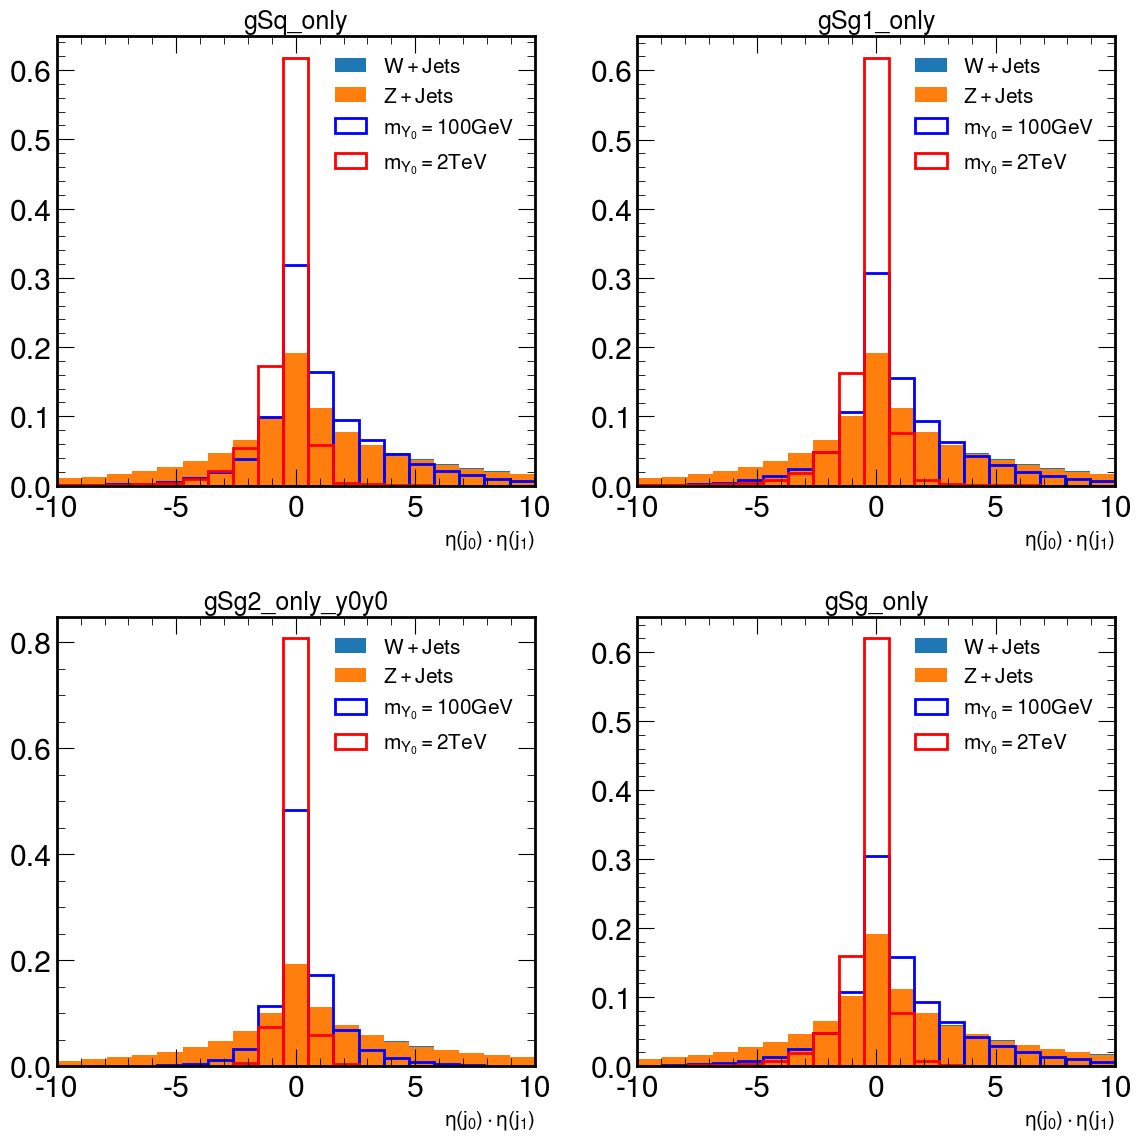

In [11]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Rapidity_prod', r"$\eta{(j_{0})}\cdot\eta{(j_{1})}$", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(-10,10))

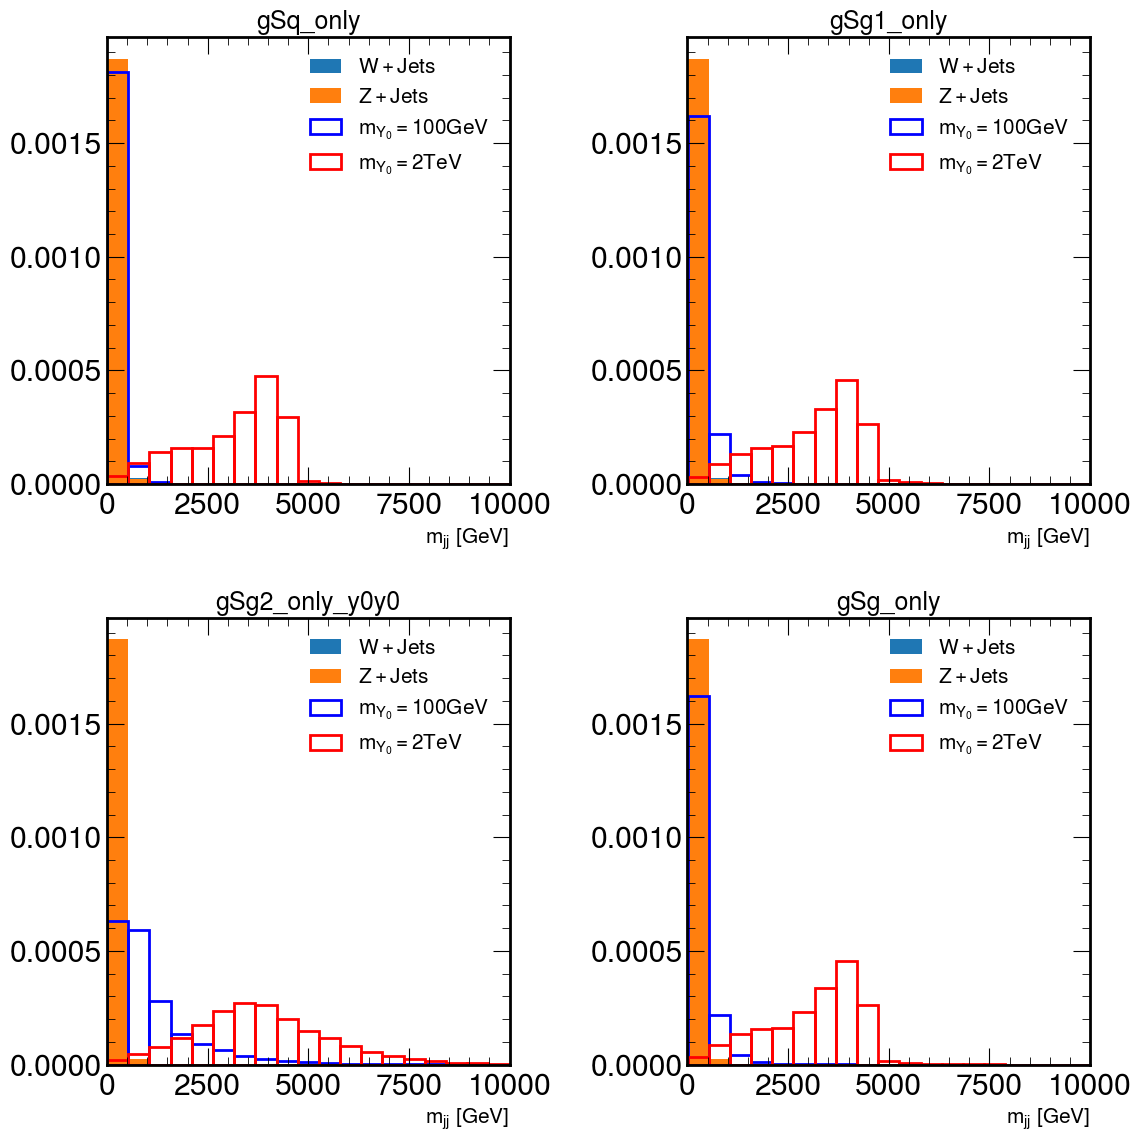

In [12]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Inv_mass', r"$m_{jj}$ [GeV]", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,10000))

In [13]:
for i in cases:
    for j in range(2):
        data[i][j] = data[i][j].query('Rapidity_prod < 0')

data_WpJ = data_WpJ.query('Rapidity_prod < 0')
data_ZpJ = data_ZpJ.query('Rapidity_prod < 0')

In [14]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])

Número de Eventos para cada caso:
	Original
Modelos:  [[34150, 63208], [37052, 59971], [41710, 51683], [36954, 59726]]
WpJets + ZpJets:  [981327, 964557]


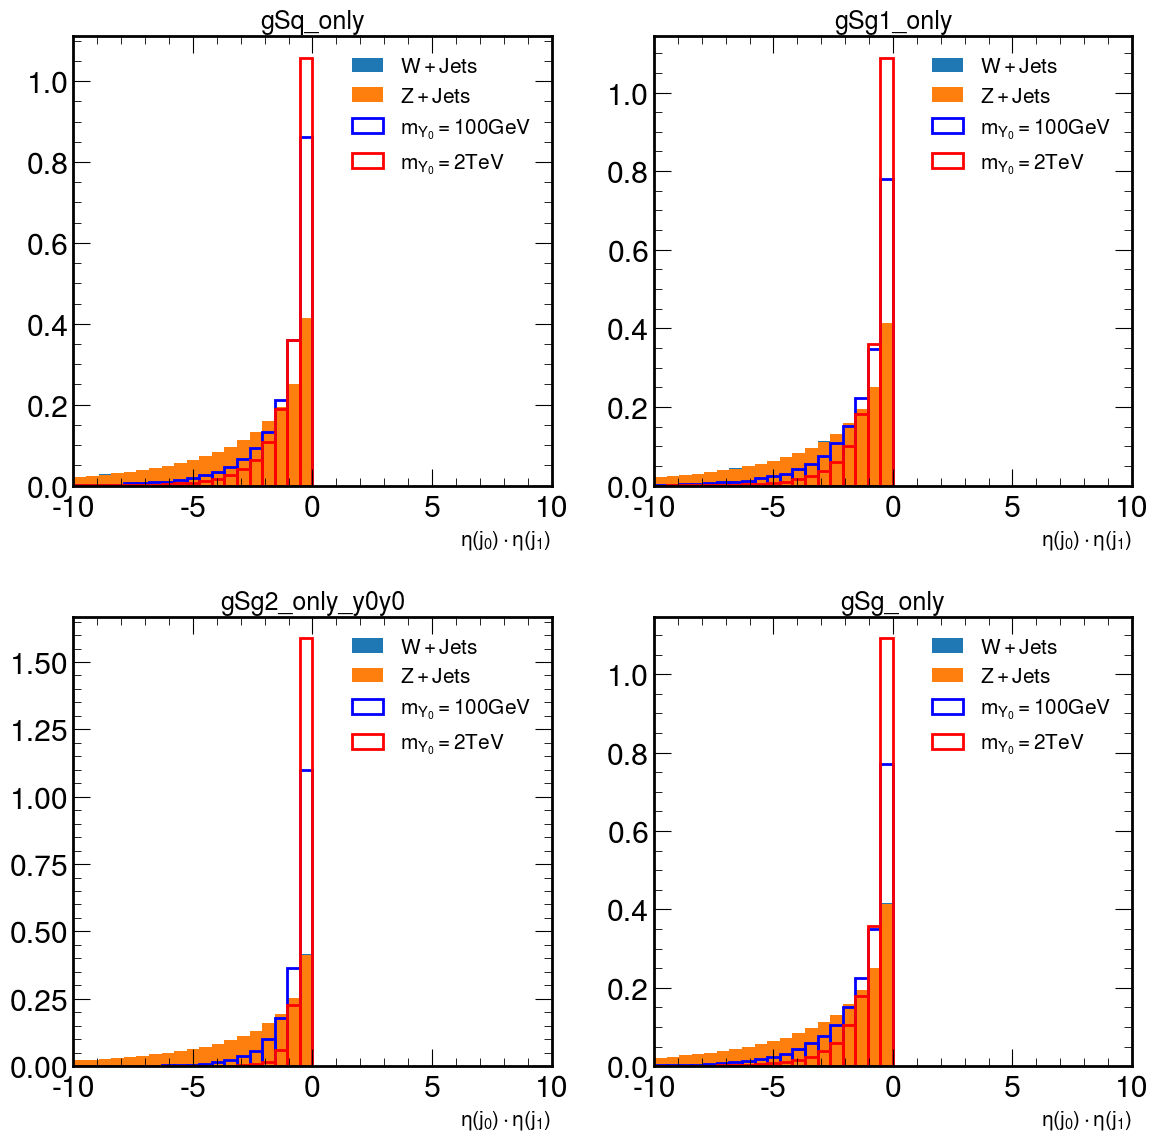

In [15]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Rapidity_prod', r"$\eta{(j_{0})}\cdot\eta{(j_{1})}$", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(-10,10))

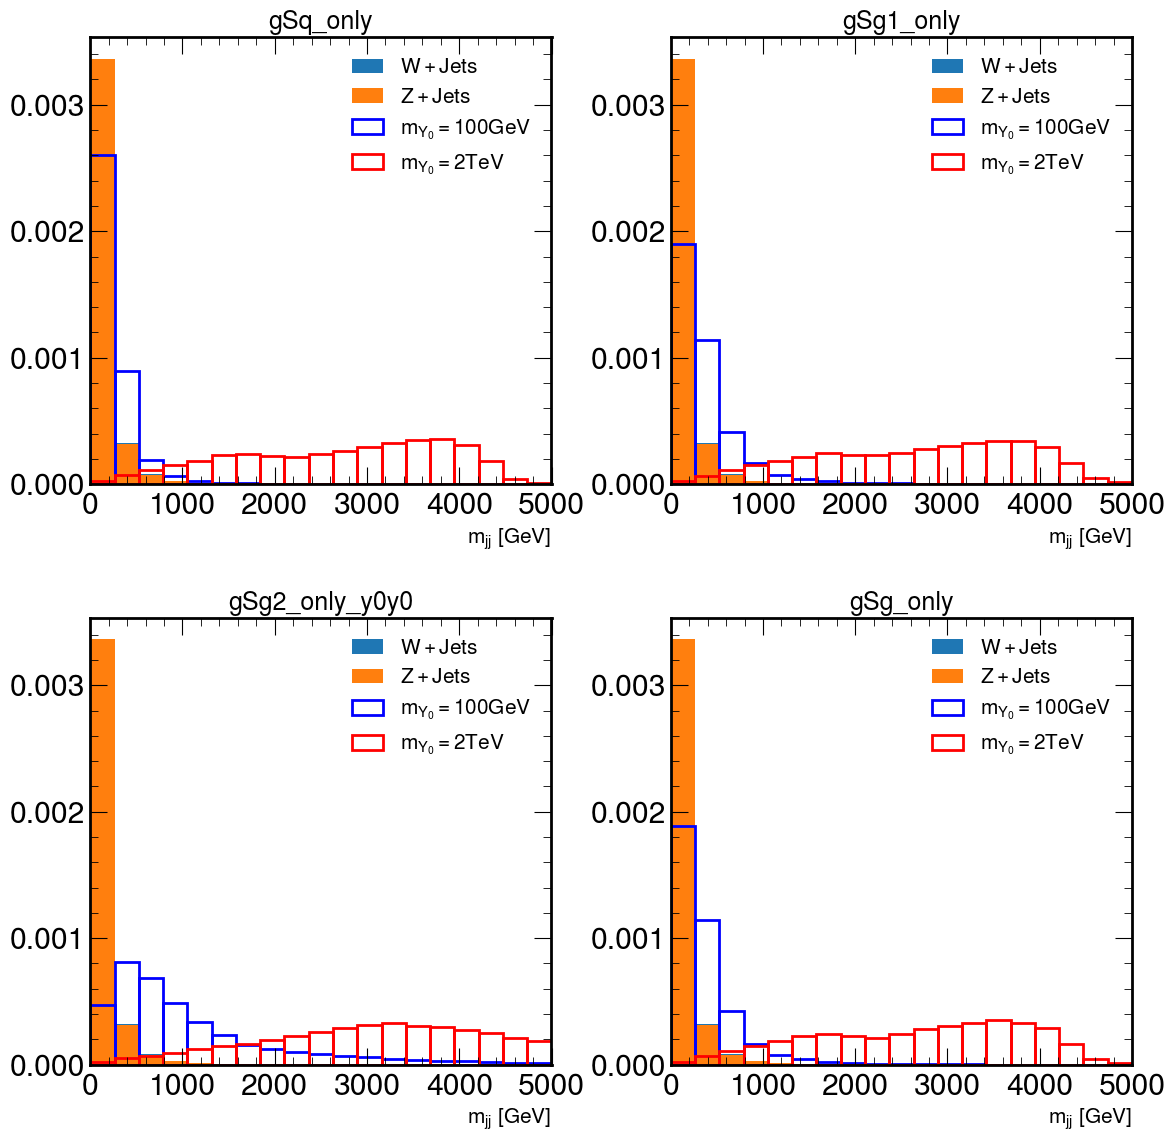

In [16]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Inv_mass', r"$m_{jj}$ [GeV]", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,5000))

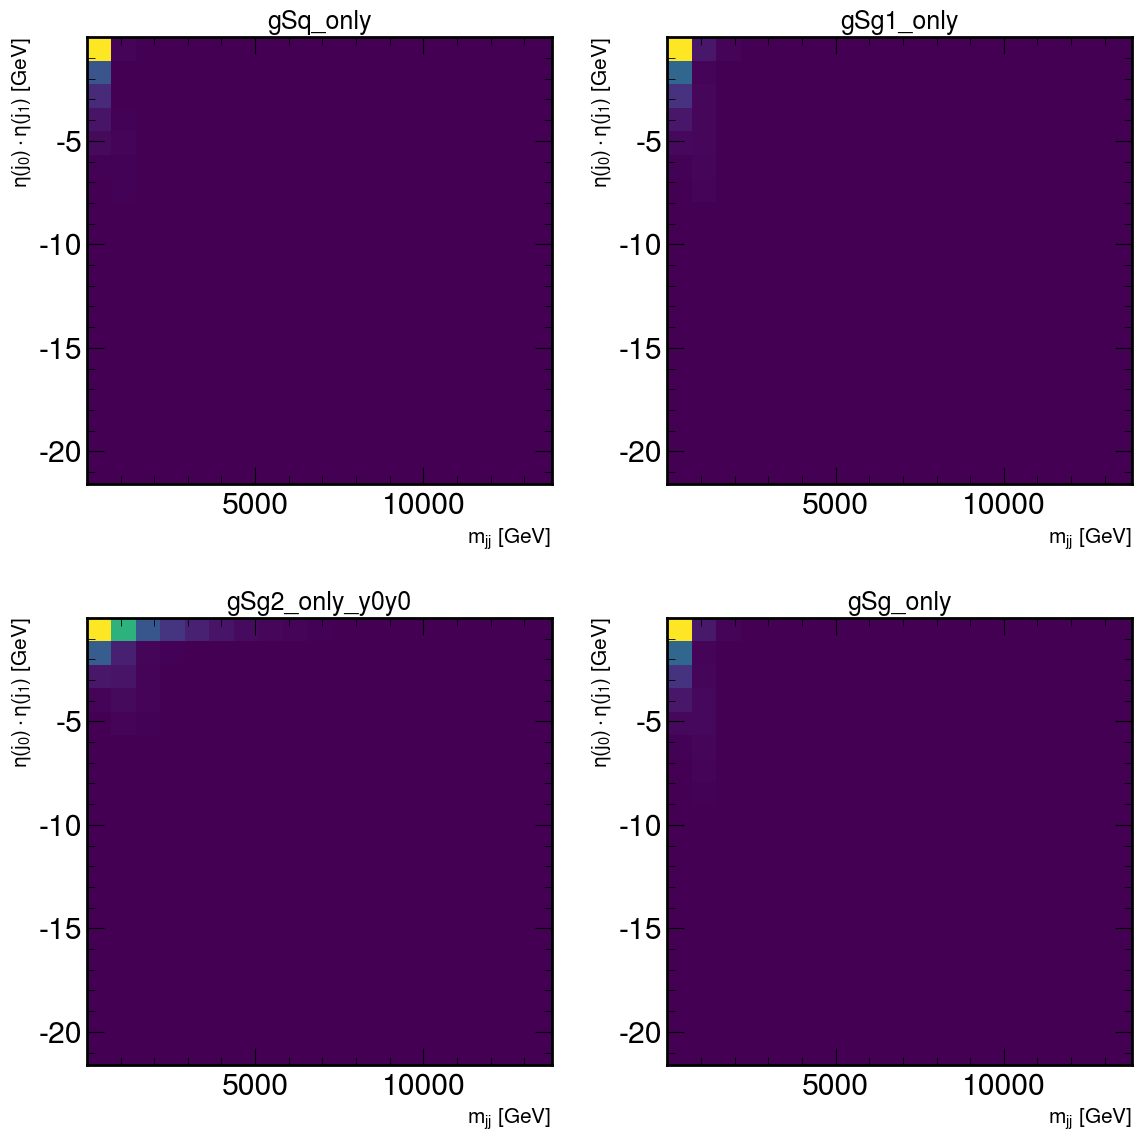

In [17]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable1 = 'Inv_mass'
variable2 = 'Rapidity_prod'
nBins = 20
#
#rangos = {}
#for i in cases:
#    rangos[i] = []
#    for j in range(2):
#        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))
#
#rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
#rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

maxValue = max([data[i][j][variable1].max() for i in cases for j in range(2)])
minValue = min([data[i][j][variable1].min() for i in cases for j in range(2)])

rango1 = np.linspace(minValue, maxValue, nBins)

maxValue = max([data[i][j][variable2].max() for i in cases for j in range(2)])
minValue = min([data[i][j][variable2].min() for i in cases for j in range(2)])

rango2 = np.linspace(minValue, maxValue, nBins)

rango = [rango1, rango2]

colors = ['blue', 'red']

#for i in range(2):
#    for j in range(2):
#        ax[i,j].hist2d(data_WpJ[variable1], data_WpJ[variable2], bins=rango, density=True)
#        ax[i,j].hist2d(data_ZpJ[variable1], data_ZpJ[variable2], bins=rango, density=True)

for i in range(1):
    ax[0,0].hist2d(data[cases[0]][i][variable1], data[cases[0]][i][variable2], bins=rango, density=True)
    ax[0,1].hist2d(data[cases[1]][i][variable1], data[cases[1]][i][variable2], bins=rango, density=True)
    ax[1,0].hist2d(data[cases[2]][i][variable1], data[cases[2]][i][variable2], bins=rango, density=True)
    ax[1,1].hist2d(data[cases[3]][i][variable1], data[cases[3]][i][variable2], bins=rango, density=True)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        #ax[i,j].vlines(1300, ymin=-15, ymax=0, color='red', linestyle='dashed')
        ax[i,j].set_xlabel(r"$m_{jj}$ [GeV]",fontsize=15)
        ax[i,j].set_ylabel(r"$\eta{(j_{0})}\cdot\eta{(j_{1})}$ [GeV]",fontsize=15)


fig.tight_layout()
plt.show()


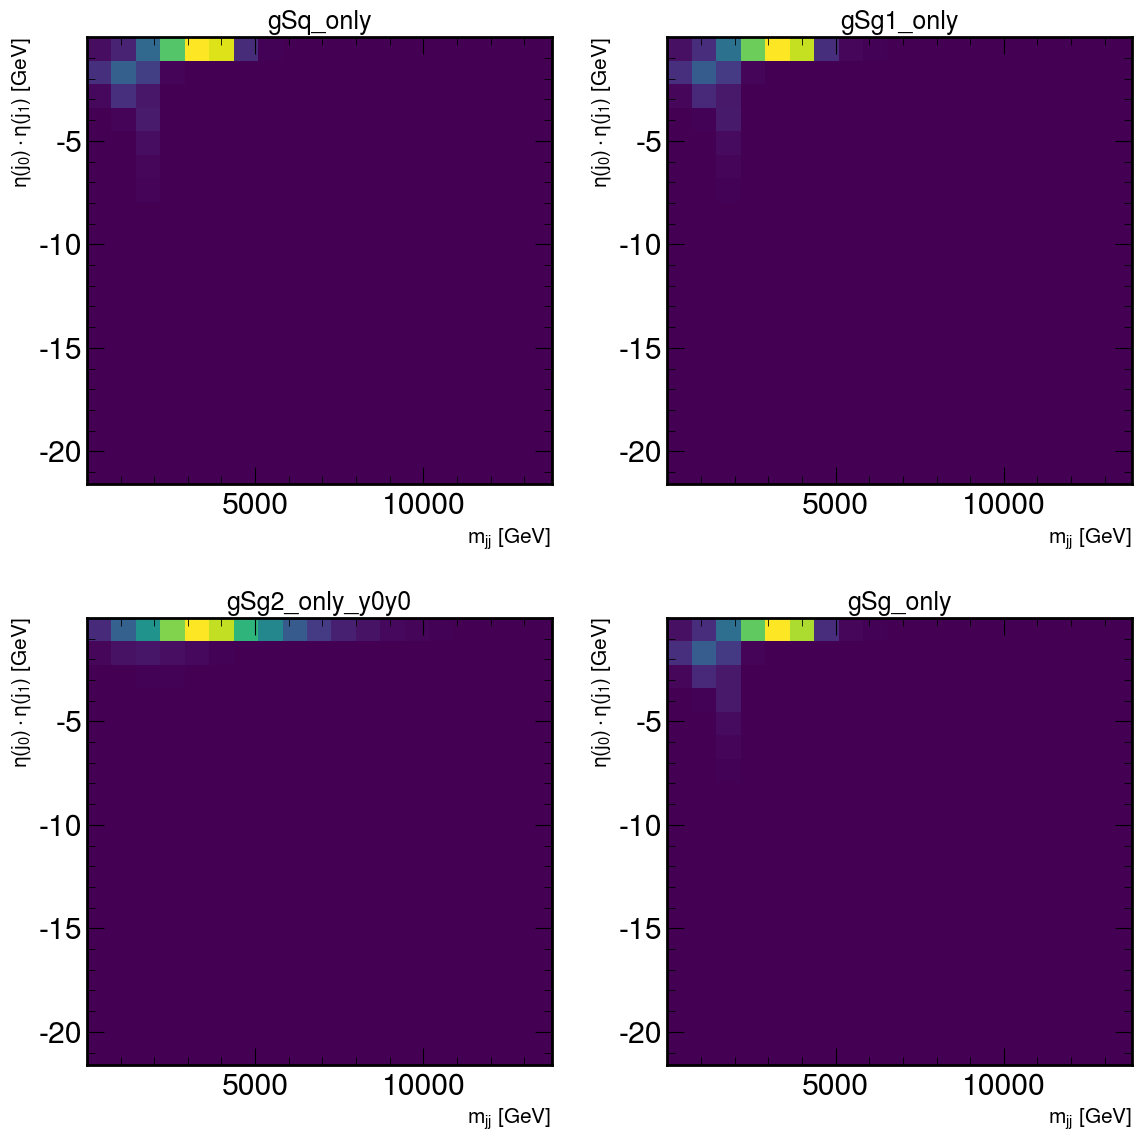

In [18]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable1 = 'Inv_mass'
variable2 = 'Rapidity_prod'
nBins = 20
#
#rangos = {}
#for i in cases:
#    rangos[i] = []
#    for j in range(2):
#        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))
#
#rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
#rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

maxValue = max([data[i][j][variable1].max() for i in cases for j in range(2)])
minValue = min([data[i][j][variable1].min() for i in cases for j in range(2)])

rango1 = np.linspace(minValue, maxValue, nBins)

maxValue = max([data[i][j][variable2].max() for i in cases for j in range(2)])
minValue = min([data[i][j][variable2].min() for i in cases for j in range(2)])

rango2 = np.linspace(minValue, maxValue, nBins)

rango = [rango1, rango2]

colors = ['blue', 'red']

#for i in range(2):
#    for j in range(2):
#        ax[i,j].hist2d(data_WpJ[variable1], data_WpJ[variable2], bins=rango, density=True)
#        ax[i,j].hist2d(data_ZpJ[variable1], data_ZpJ[variable2], bins=rango, density=True)

for i in range(1,2):
    ax[0,0].hist2d(data[cases[0]][i][variable1], data[cases[0]][i][variable2], bins=rango, density=True)
    ax[0,1].hist2d(data[cases[1]][i][variable1], data[cases[1]][i][variable2], bins=rango, density=True)
    ax[1,0].hist2d(data[cases[2]][i][variable1], data[cases[2]][i][variable2], bins=rango, density=True)
    ax[1,1].hist2d(data[cases[3]][i][variable1], data[cases[3]][i][variable2], bins=rango, density=True)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        #ax[i,j].vlines(3000, ymin=-15, ymax=0, color='red', linestyle='dashed')
        ax[i,j].set_xlabel(r"$m_{jj}$ [GeV]",fontsize=15)
        ax[i,j].set_ylabel(r"$\eta{(j_{0})}\cdot\eta{(j_{1})}$ [GeV]",fontsize=15)


fig.tight_layout()
plt.show()


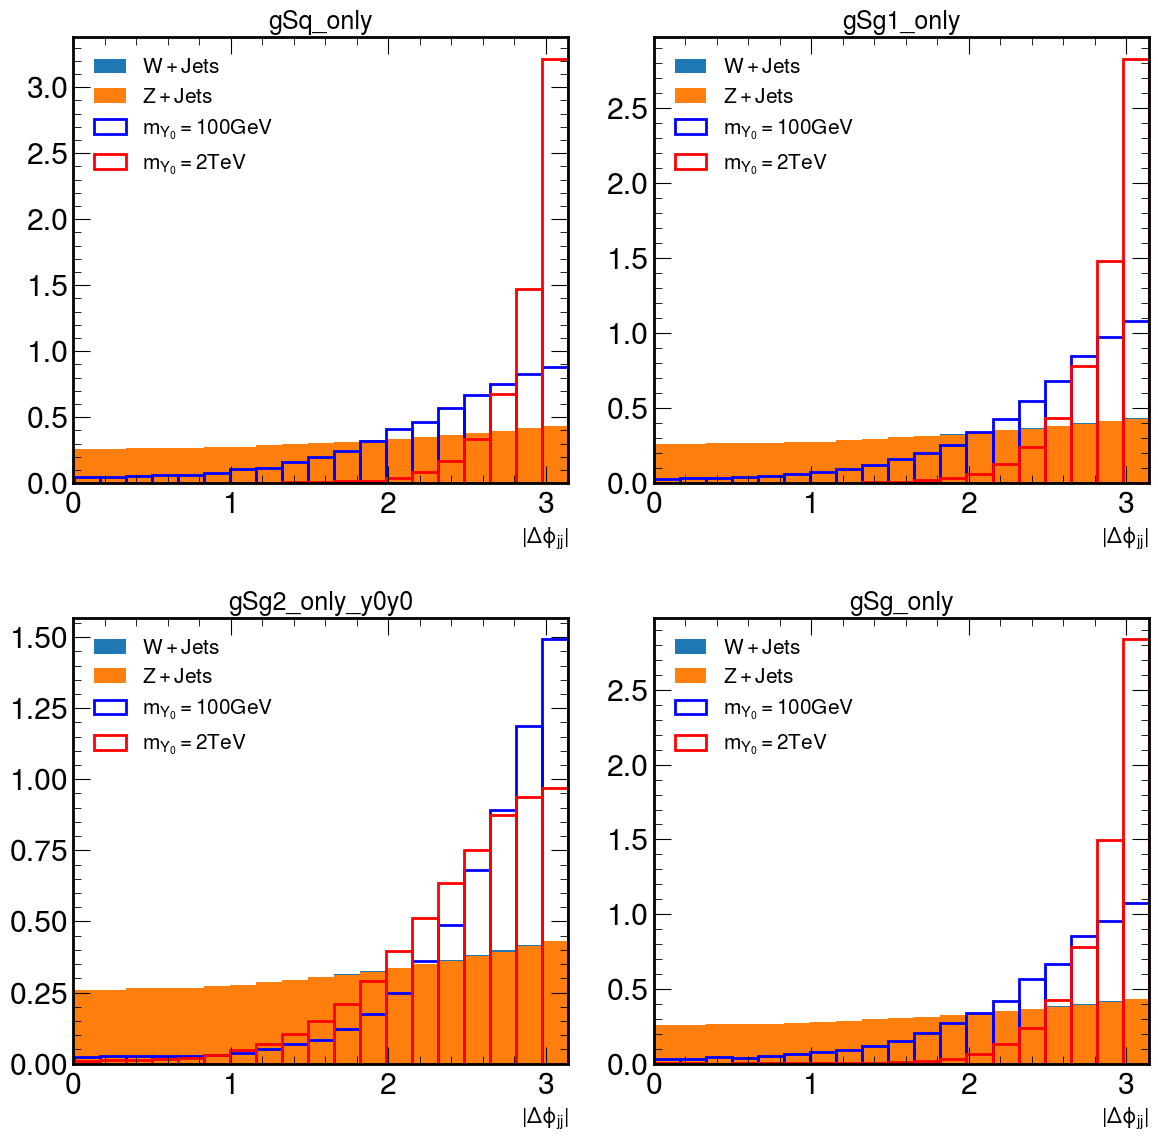

In [19]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Delta_phi', r"$|\Delta\phi_{jj}|$", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,np.pi))

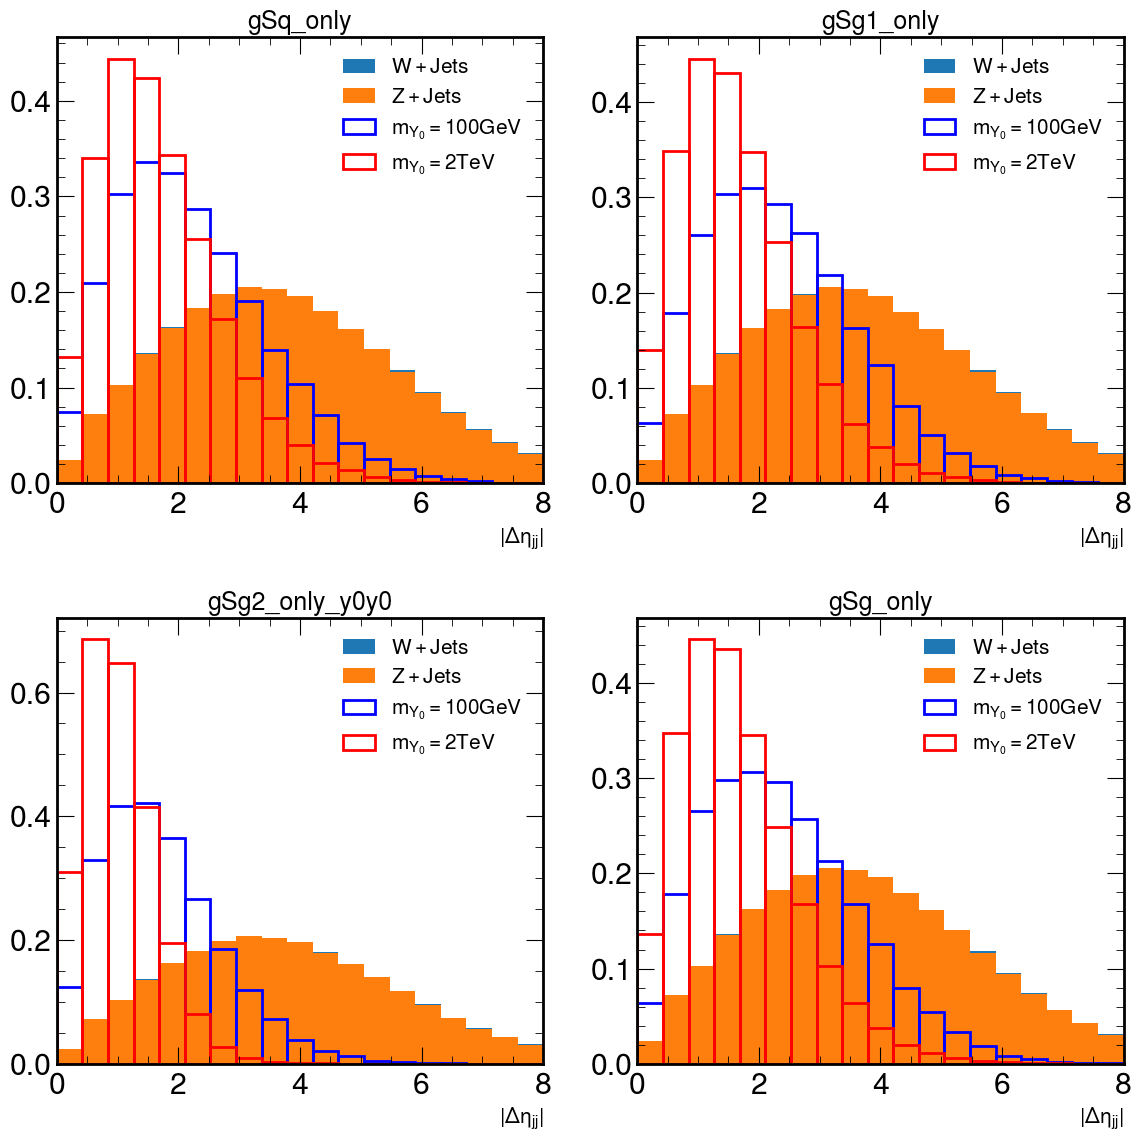

In [20]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Delta_rapidity', r"$|\Delta\eta_{jj}|$", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,8))

# Significance

Weights

$$W = \frac{N_{fisicos}}{N_{MG+Pythia}}$$

In [21]:
Weights = pd.read_csv("BGweigths.csv").to_dict()
# Luminosity to normalize
lum = 1 # fb-1

for i in cases:
    Weights[i] = []
    for j in range(2):
        Weights[i].append(CSs[i][j]*1000*lum/data[i][j].shape[0])

In [22]:
Weights['WpJets'] = Weights['WpJets'][0]
Weights['ZpJets'] = Weights['ZpJets'][0]
Weights.pop('Unnamed: 0')

{0: 0}

In [23]:
Weights

{'WpJets': 12.901682938859402,
 'ZpJets': 3.706521439496522,
 'gSq_only': [0.0029282576866764276, 0.0015820782179470953],
 'gSg1_only': [5.674862355608334, 0.11617281686148306],
 'gSg2_only_y0y0': [0.002397506593143131, 0.0019348722016910784],
 'gSg_only': [5.692347242517725, 0.11663764524662626]}

### Cut in $p_{T}(j_{0})$

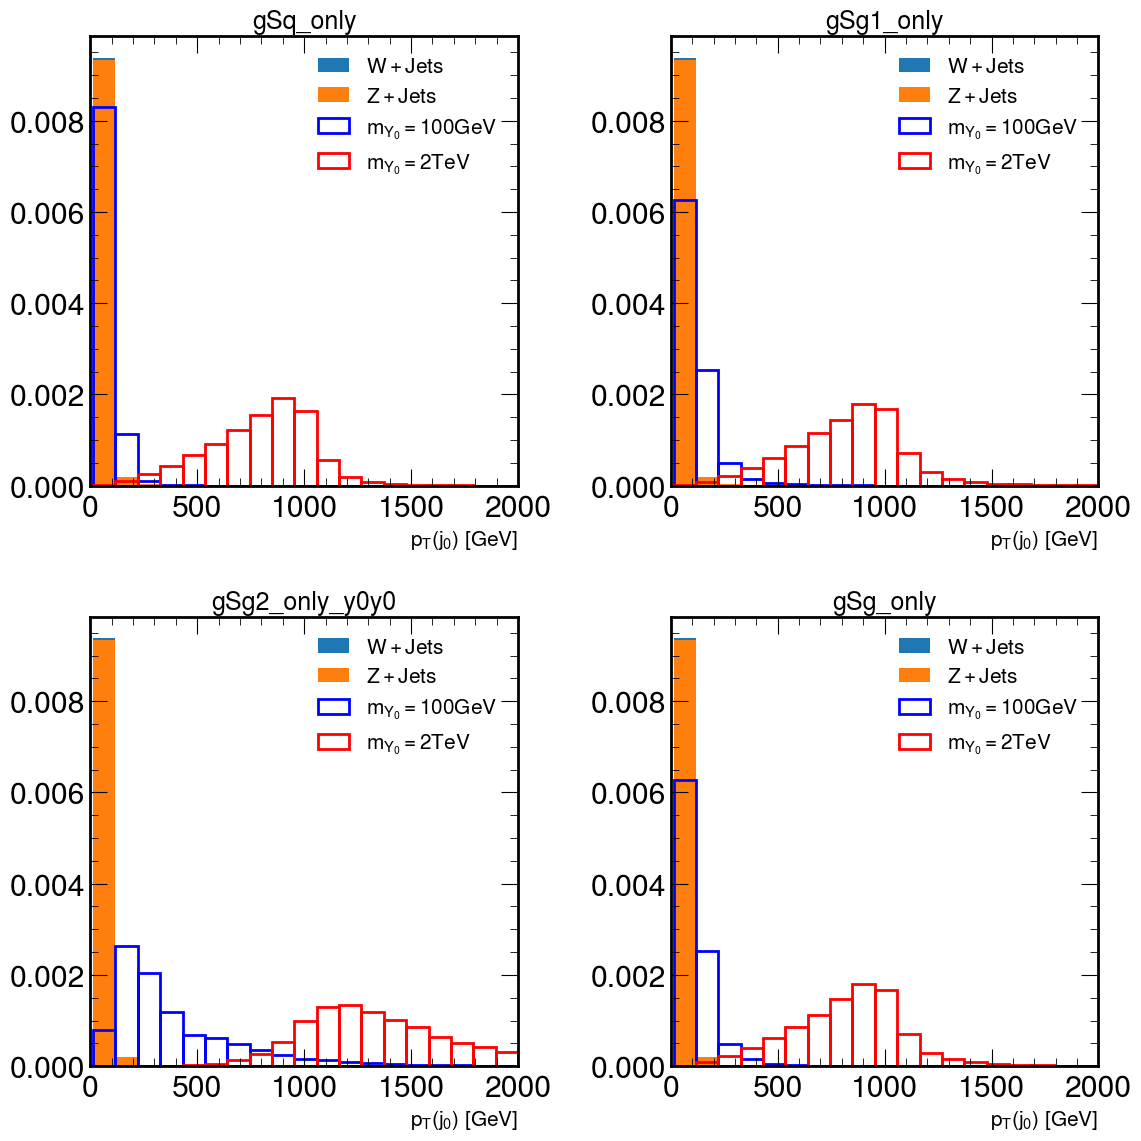

In [24]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'jet_pt0', r"$p_{T}{(j_{0})}$ [GeV]", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,2000))

In [26]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt0', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:349: RuntimeWarning: invalid value encountered in scalar divide
  Z[i][j][k] = S / np.sqrt(S + B)


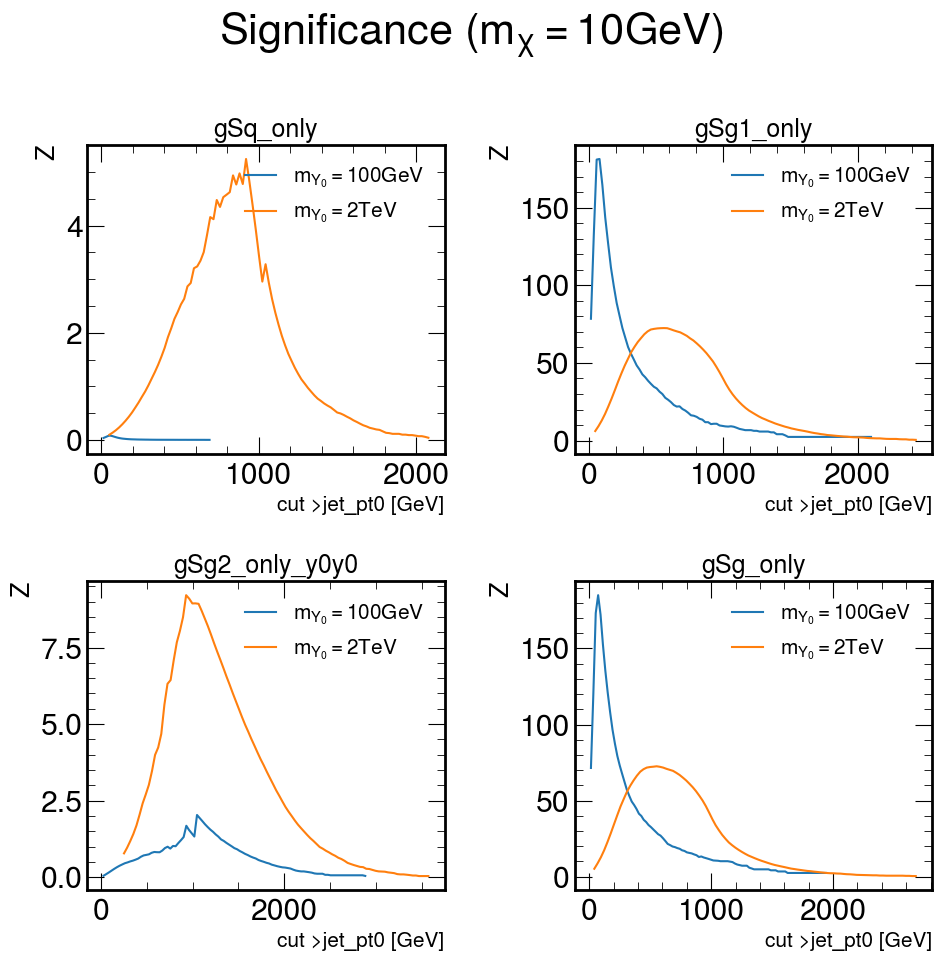

In [27]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

Acotamos el rango de busqueda

In [28]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt0', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']],
                                 set_lims=True, lims=(0,1500), size=500)

In [29]:
cuts = get_cuts(cases, Z, pt_values, "jet_pt0", "GeV", ["my0=100GeV", "my0=2TeV"], printResults=True)

case : gSq_only
	mass point: my0=100GeV
		max significance: 0.07903257584731727
		cut: jet_pt0 > 55.14GeV
	mass point: my0=2TeV
		max significance: 5.353127721683226
		cut: jet_pt0 > 913.62GeV
case : gSg1_only
	mass point: my0=100GeV
		max significance: 185.22632420770657
		cut: jet_pt0 > 66.643GeV
	mass point: my0=2TeV
		max significance: 72.58465456046967
		cut: jet_pt0 > 542.736GeV
case : gSg2_only_y0y0
	mass point: my0=100GeV
		max significance: 2.071602471934759
		cut: jet_pt0 > 1040.109GeV
	mass point: my0=2TeV
		max significance: 9.260699292236335
		cut: jet_pt0 > 912.466GeV
case : gSg_only
	mass point: my0=100GeV
		max significance: 185.46279857062882
		cut: jet_pt0 > 69.934GeV
	mass point: my0=2TeV
		max significance: 72.5453683228701
		cut: jet_pt0 > 549.697GeV


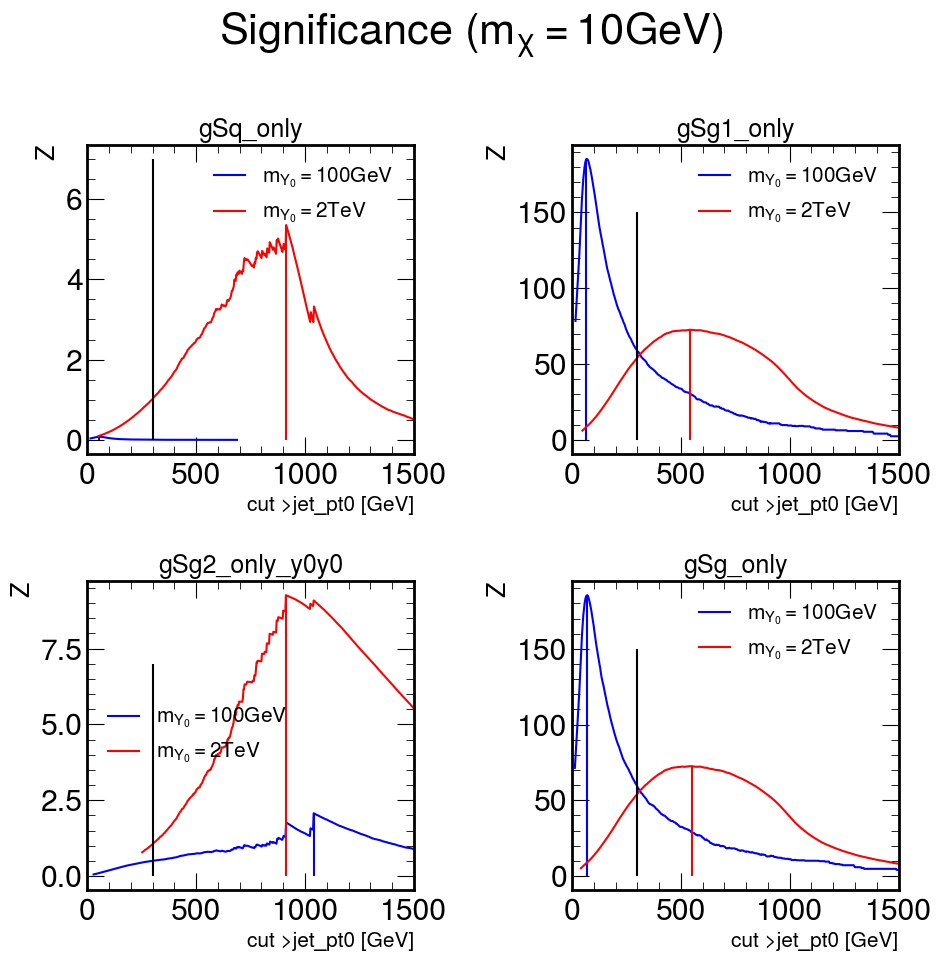

In [30]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

colors = ["b","r"]
labels = [r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"]

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i],color=colors[i], label=labels[i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i],color=colors[i], label=labels[i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i],color=colors[i], label=labels[i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i],color=colors[i], label=labels[i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=max(Z[cases[0]][i]),color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=max(Z[cases[1]][i]),color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=max(Z[cases[2]][i]),color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=max(Z[cases[3]][i]),color=colors[i])

ax[0,0].vlines(300, ymin=0, ymax=7, color='black')
ax[0,1].vlines(300, ymin=0, ymax=150, color='black')
ax[1,0].vlines(300, ymin=0, ymax=7, color='black')
ax[1,1].vlines(300, ymin=0, ymax=150, color='black')

for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1500)

fig.tight_layout()
plt.show()

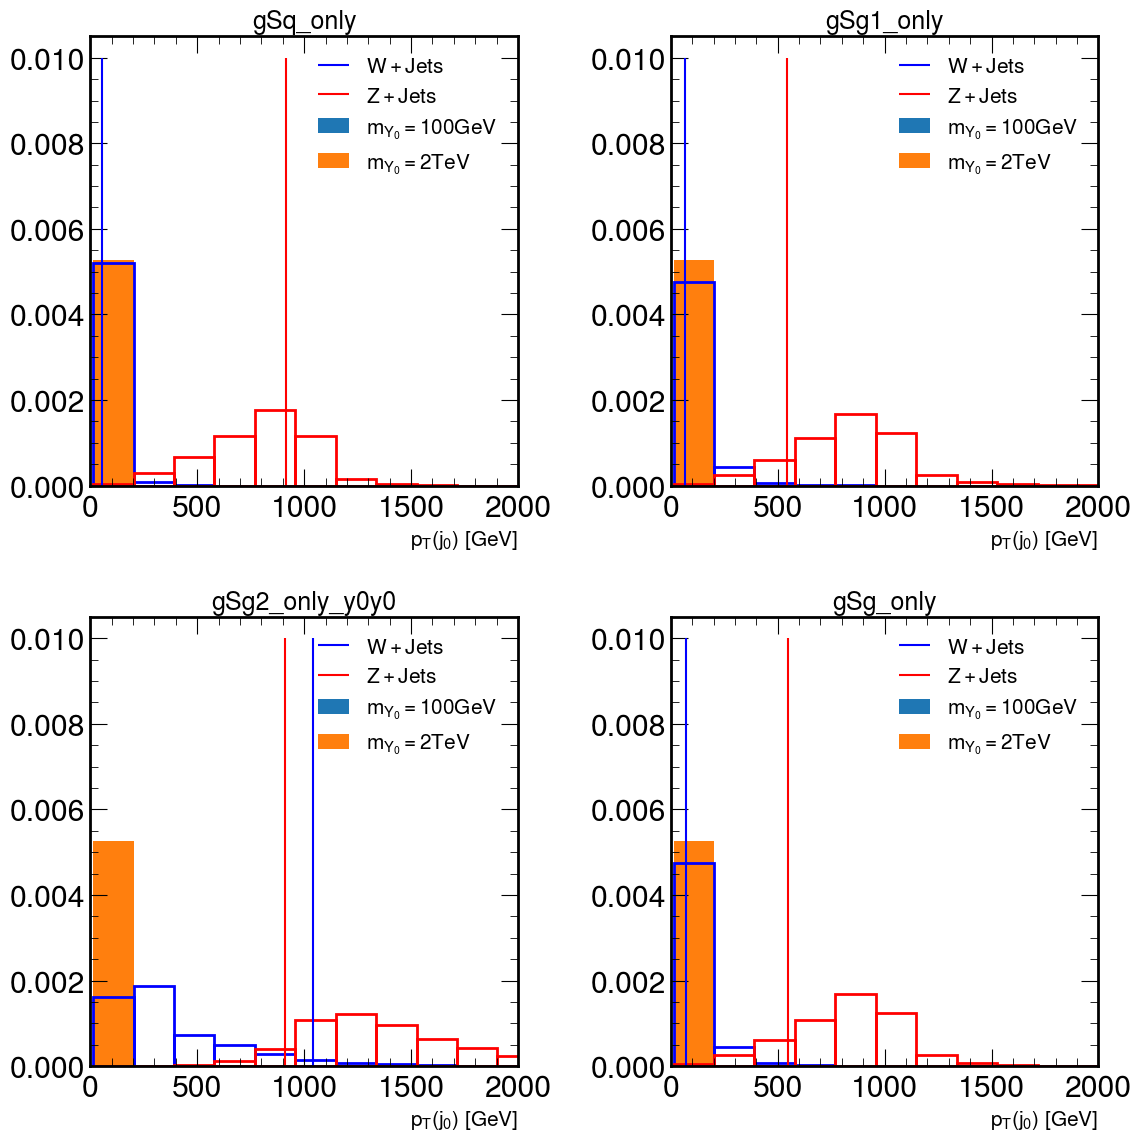

In [31]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'jet_pt0'
nBins = 20

#rangos = {}
#for i in cases:
#    rangos[i] = []
#    for j in range(2):
#        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))
#
#rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
#rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

maxValue = max([data[i][j][variable].max() for i in cases for j in range(2)])
minValue = min([data[i][j][variable].min() for i in cases for j in range(2)])

rango = np.linspace(minValue, maxValue, nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rango, density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rango, density=True)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rango, density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rango, density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rango, density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rango, density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=0.01,color=colors[i])

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$p_{T}{(j_{0})}$ [GeV]",fontsize=15)
        ax[i,j].set_xlim(0,2000)


fig.tight_layout()
plt.show()


Cut in 200GeV

In [32]:
for i in cases:
    for j in range(2):
        data[i][j] = data[i][j].query('jet_pt0 > 200')

data_WpJ = data_WpJ.query('jet_pt0 > 200')
data_ZpJ = data_ZpJ.query('jet_pt0 > 200')

In [33]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])

Número de Eventos para cada caso:
	Original
Modelos:  [[616, 62655], [3865, 59534], [29198, 51683], [3848, 59318]]
WpJets + ZpJets:  [2020, 2378]


### Cut in $p_{T}{(j_{1})}$

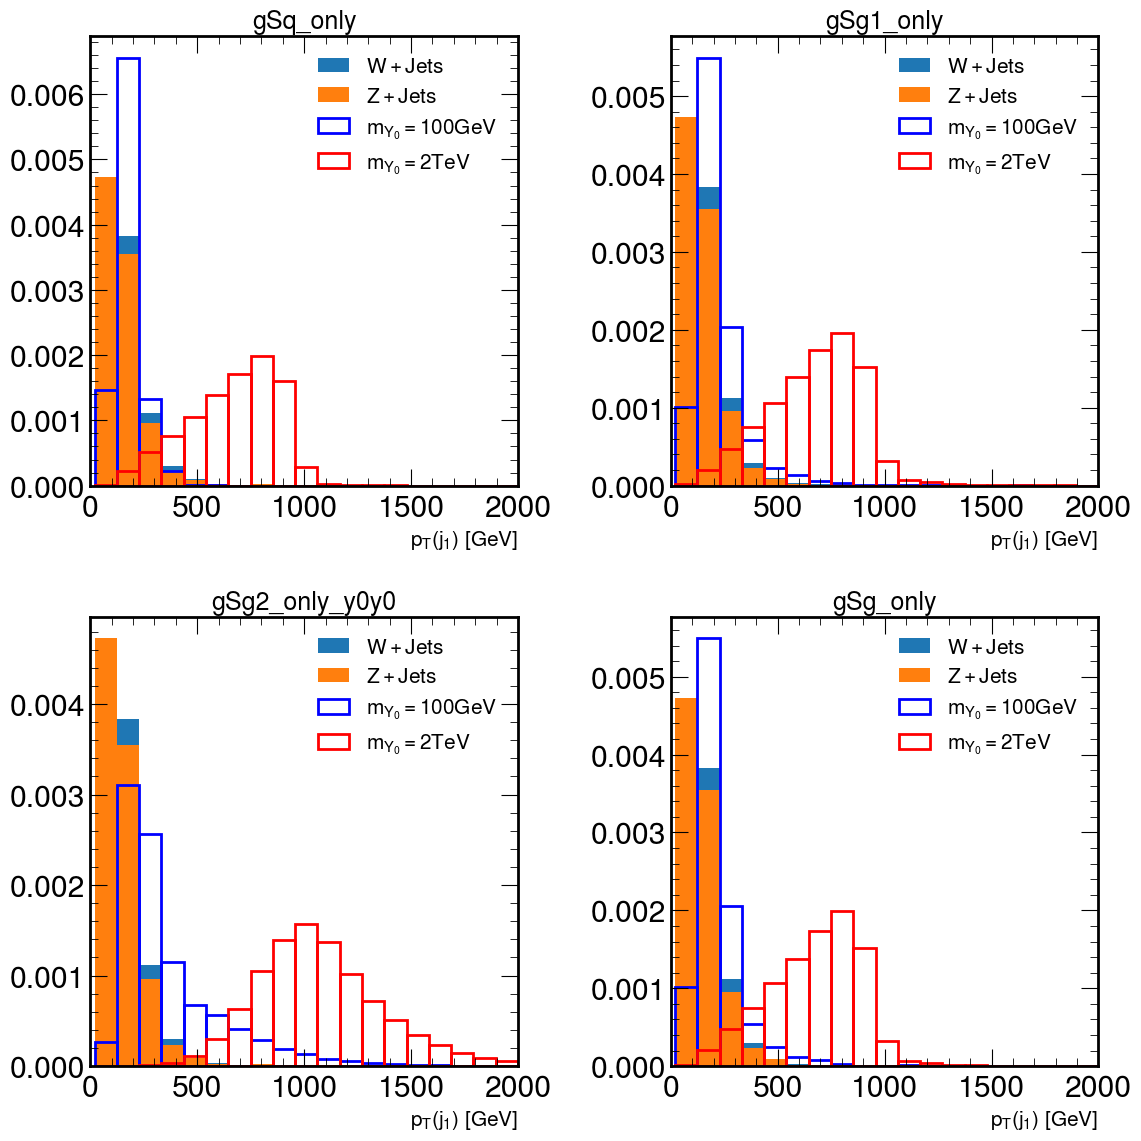

In [34]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'jet_pt1', r"$p_{T}{(j_{1})}$ [GeV]", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,2000))

In [35]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt1', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

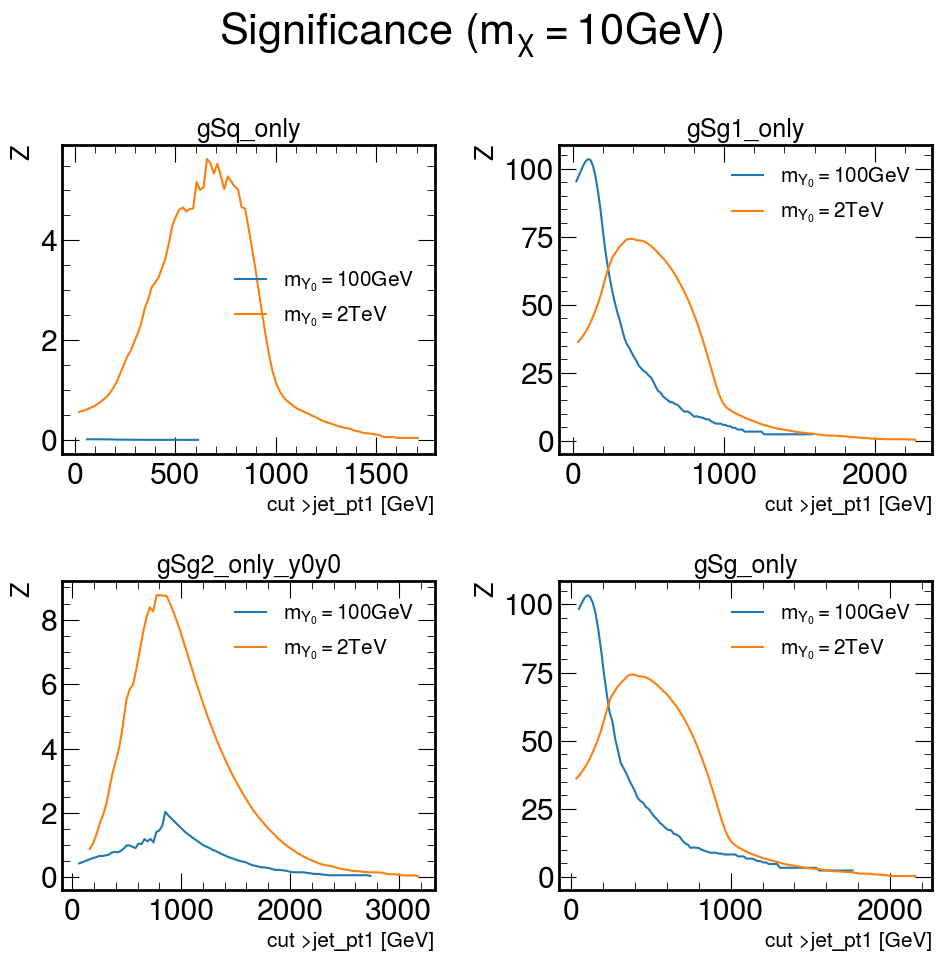

In [36]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

In [37]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt1', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']],
                                 set_lims=True, lims=(0,1000), size=500)

In [38]:
cuts = get_cuts(cases, Z, pt_values, "jet_pt1", "GeV", ["my0=100GeV", "my0=2TeV"], printResults=True)

case : gSq_only
	mass point: my0=100GeV
		max significance: 0.011975799036472676
		cut: jet_pt1 > 106.352GeV
	mass point: my0=2TeV
		max significance: 5.68130913408539
		cut: jet_pt1 > 652.455GeV
case : gSg1_only
	mass point: my0=100GeV
		max significance: 103.58634813516794
		cut: jet_pt1 > 102.661GeV
	mass point: my0=2TeV
		max significance: 74.4063691535641
		cut: jet_pt1 > 384.192GeV
case : gSg2_only_y0y0
	mass point: my0=100GeV
		max significance: 2.0860188078142494
		cut: jet_pt1 > 843.964GeV
	mass point: my0=2TeV
		max significance: 8.897270726901992
		cut: jet_pt1 > 843.1GeV
case : gSg_only
	mass point: my0=100GeV
		max significance: 103.29622240168386
		cut: jet_pt1 > 98.215GeV
	mass point: my0=2TeV
		max significance: 74.33956799250414
		cut: jet_pt1 > 384.427GeV


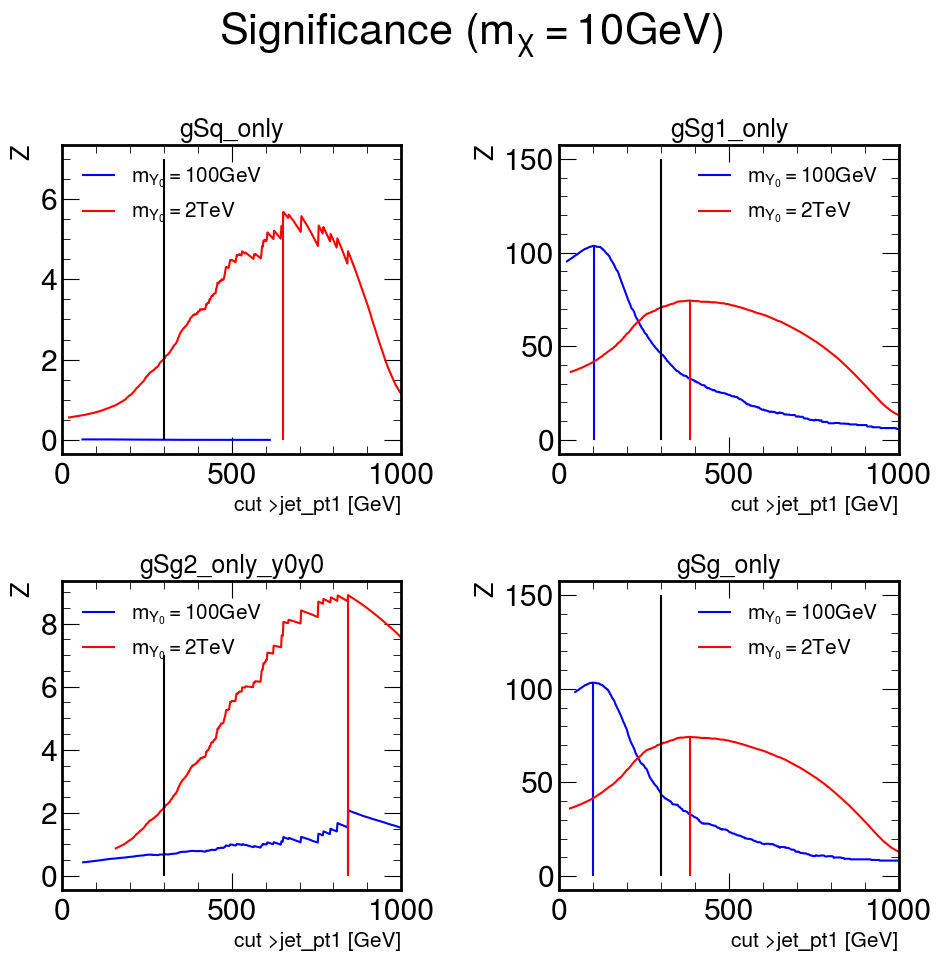

In [39]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

colors = ["b","r"]
labels = [r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"]

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i],color=colors[i], label=labels[i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i],color=colors[i], label=labels[i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i],color=colors[i], label=labels[i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i],color=colors[i], label=labels[i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=max(Z[cases[0]][i]),color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=max(Z[cases[1]][i]),color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=max(Z[cases[2]][i]),color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=max(Z[cases[3]][i]),color=colors[i])

ax[0,0].vlines(300, ymin=0, ymax=7, color='black')
ax[0,1].vlines(300, ymin=0, ymax=150, color='black')
ax[1,0].vlines(300, ymin=0, ymax=7, color='black')
ax[1,1].vlines(300, ymin=0, ymax=150, color='black')

for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1000)

fig.tight_layout()
plt.show()

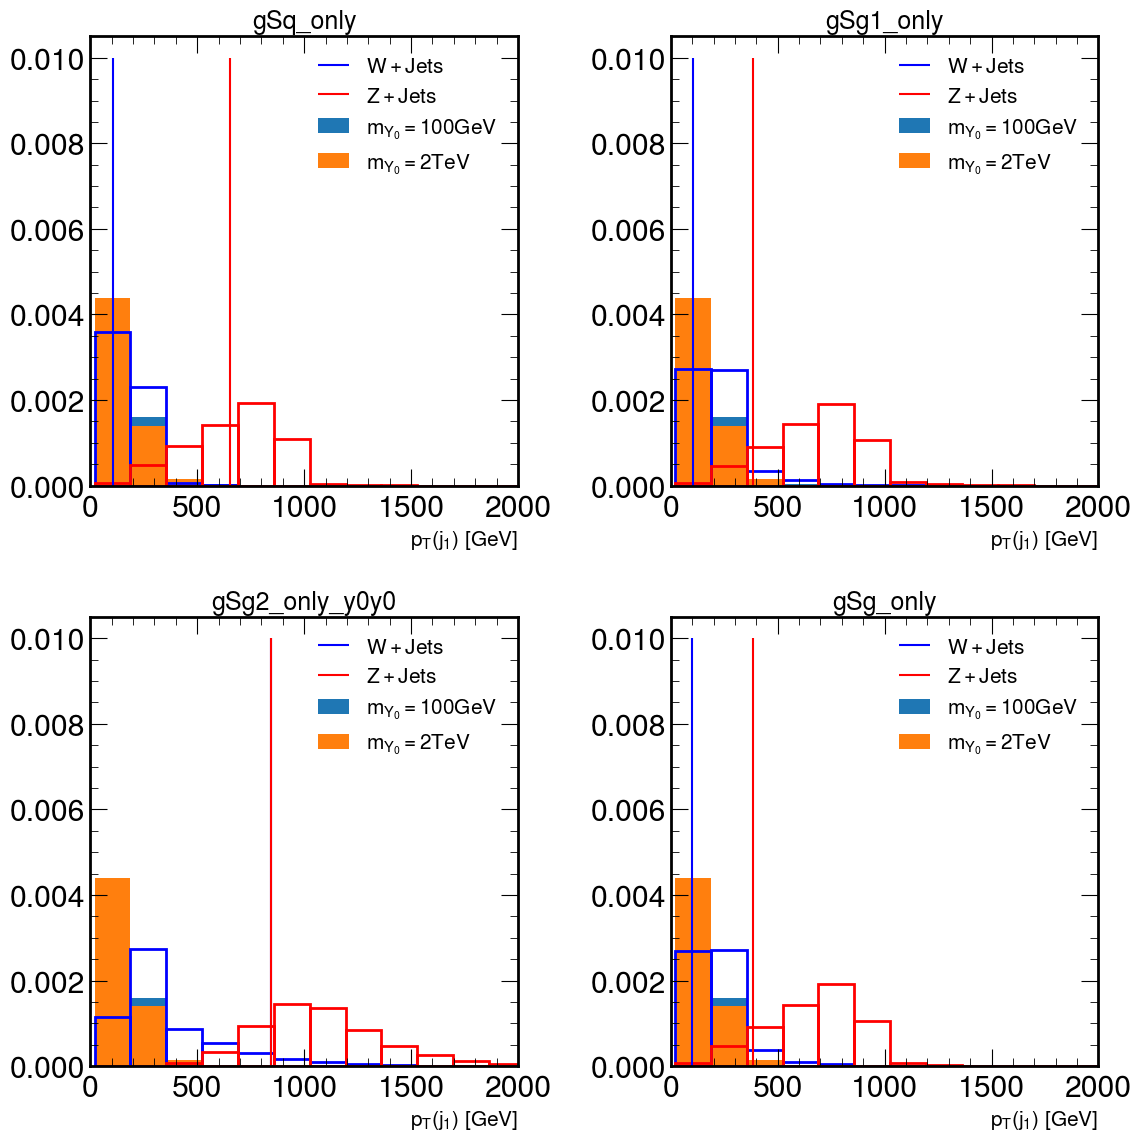

In [40]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'jet_pt1'
nBins = 20

#rangos = {}
#for i in cases:
#    rangos[i] = []
#    for j in range(2):
#        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))
#
#rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
#rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

maxValue = max([data[i][j][variable].max() for i in cases for j in range(2)])
minValue = min([data[i][j][variable].min() for i in cases for j in range(2)])

rango = np.linspace(minValue, maxValue, nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rango, density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rango, density=True)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rango, density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rango, density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rango, density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rango, density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=0.01,color=colors[i])

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$p_{T}{(j_{1})}$ [GeV]",fontsize=15)
        ax[i,j].set_xlim(0,2000)


fig.tight_layout()
plt.show()

Make cut in 300GeV

In [41]:
for i in cases:
    for j in range(2):
        data[i][j] = data[i][j].query('jet_pt1 > 300')

data_WpJ = data_WpJ.query('jet_pt1 > 300')
data_ZpJ = data_ZpJ.query('jet_pt1 > 300')

In [42]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])

Número de Eventos para cada caso:
	Original
Modelos:  [[26, 58929], [597, 56310], [12938, 51662], [555, 56019]]
WpJets + ZpJets:  [127, 111]


## Plot $p_{T}^{miss}$

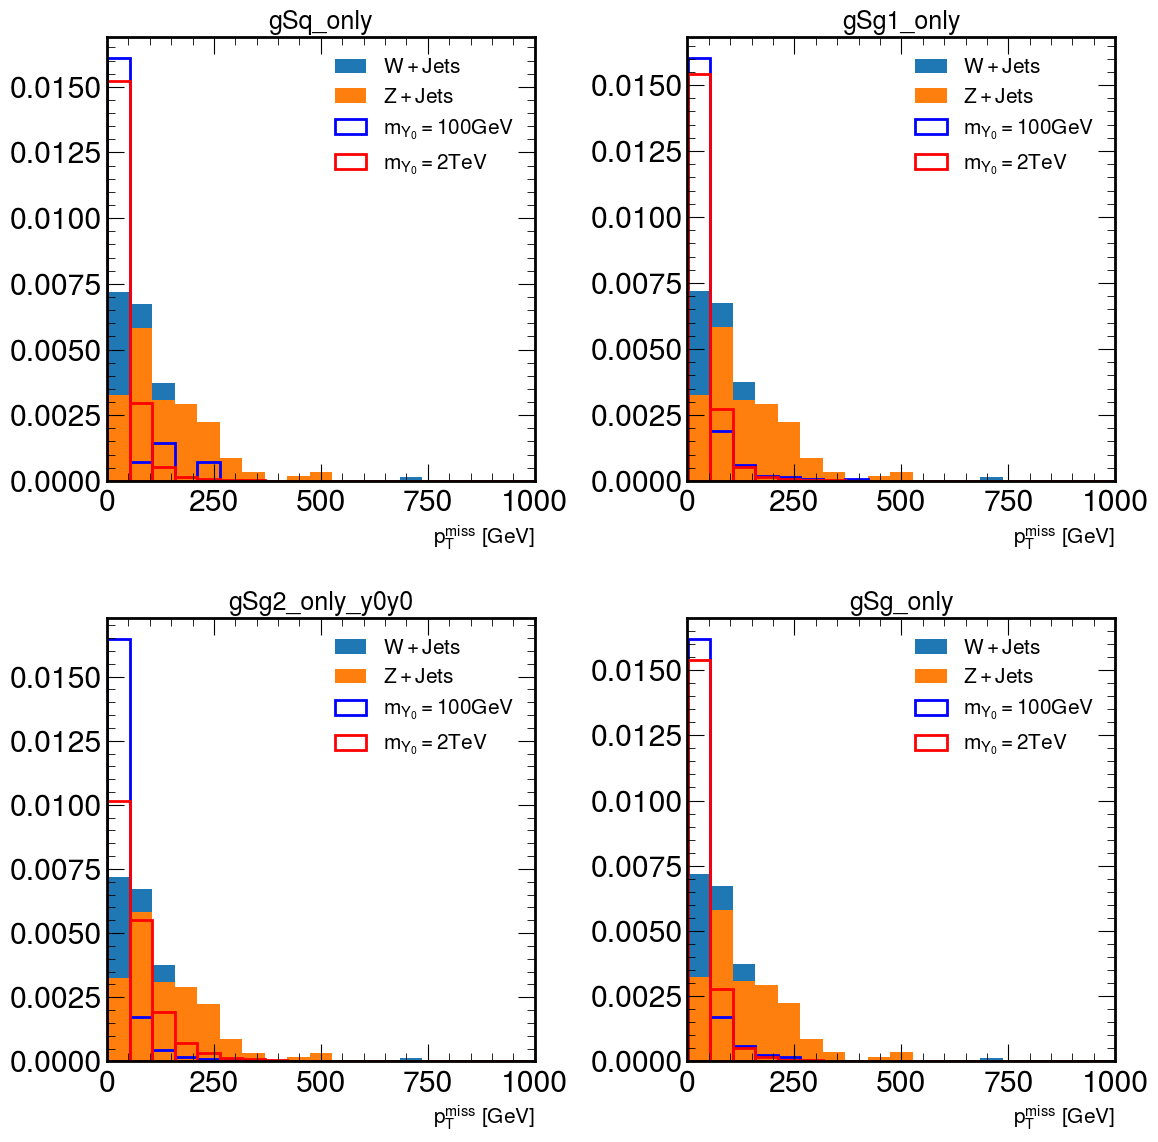

In [43]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'missinget_met', r"$p_{T}^{miss}$ [GeV]", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,1000))

#### VBF variables

$\eta(j_{0}) \cdot \eta(j_{1})$

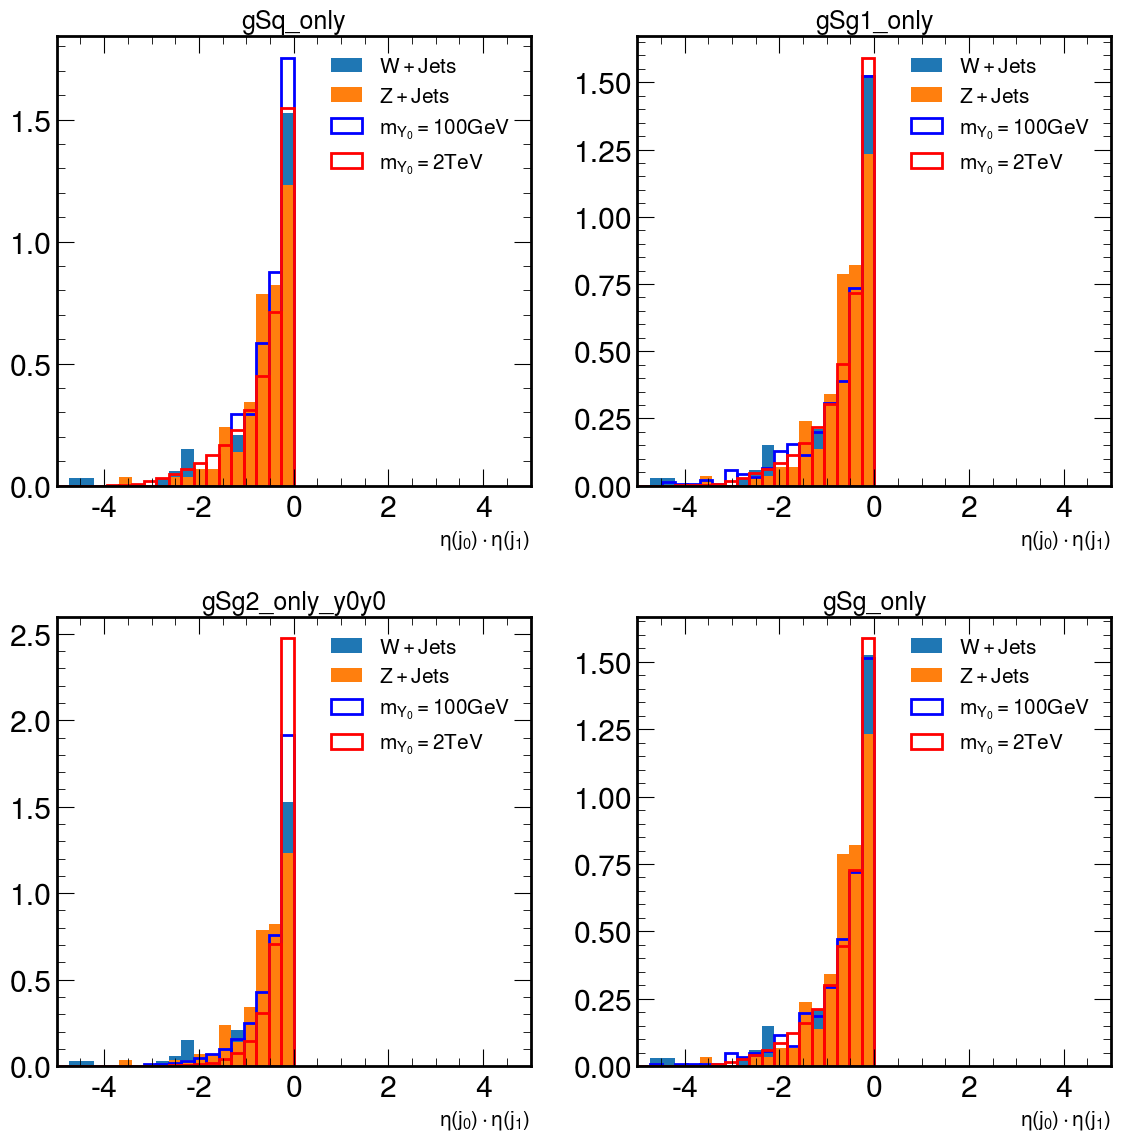

In [44]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Rapidity_prod', r"$\eta{(j_{0})}\cdot\eta{(j_{1})}$", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(-5,5))

In [45]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='Rapidity_prod', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']], cond='<')

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:349: RuntimeWarning: invalid value encountered in scalar divide
  Z[i][j][k] = S / np.sqrt(S + B)


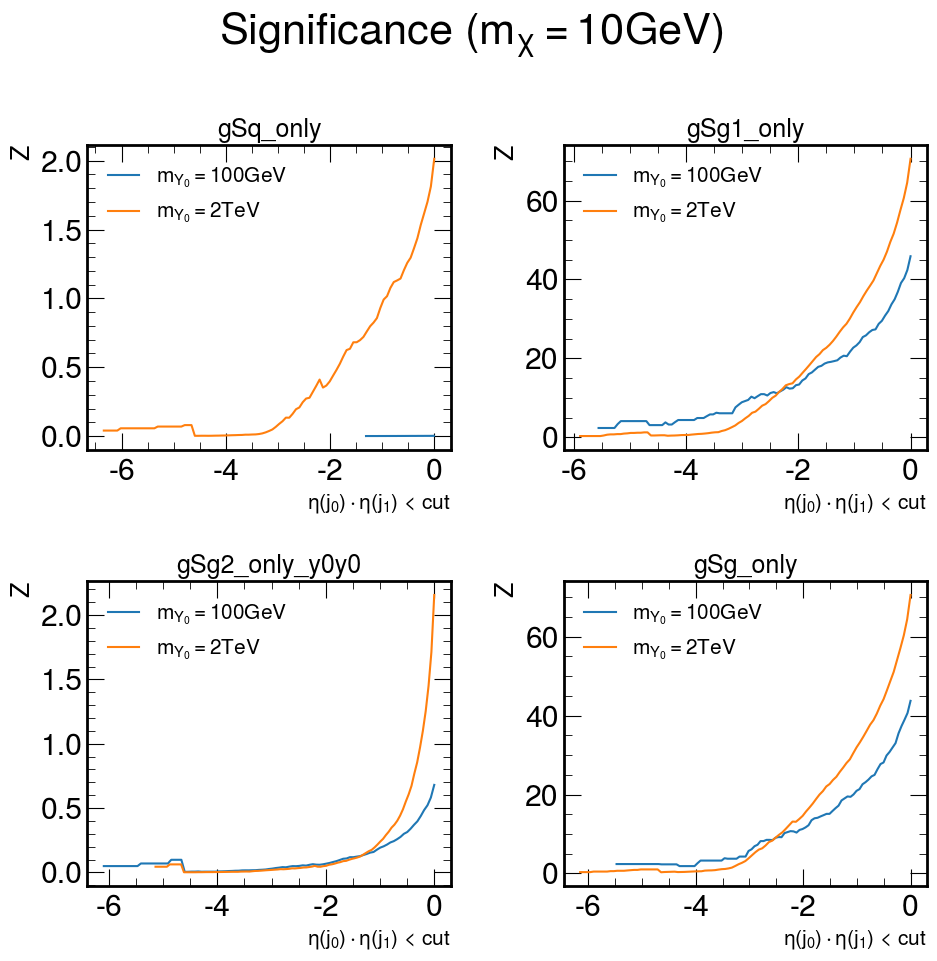

In [46]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\eta{(j_{0})}\cdot\eta{(j_{1})}$ < cut",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

### $\Delta\phi_{jj}$

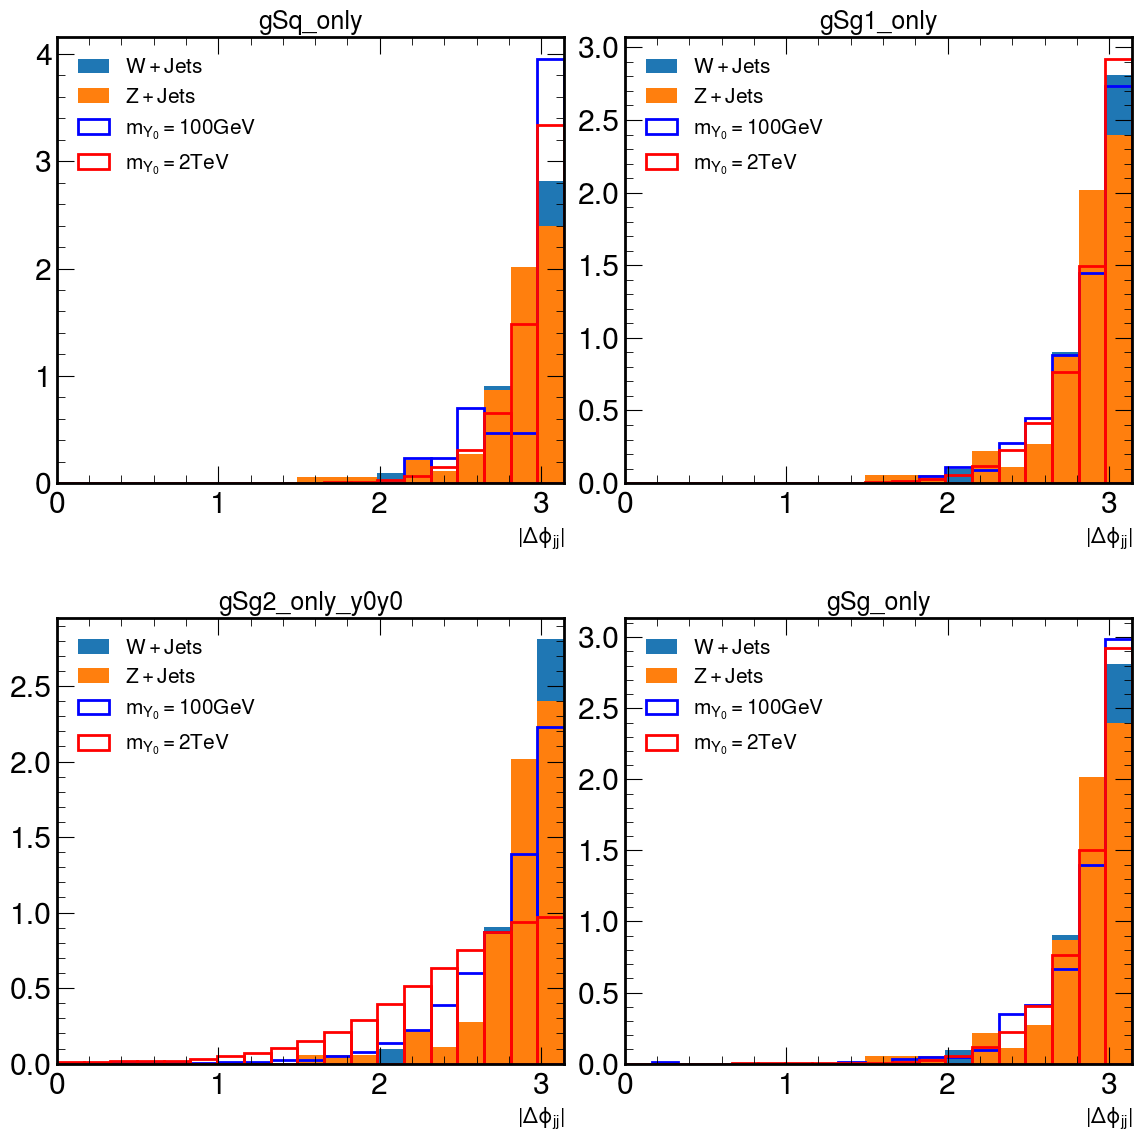

In [48]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Delta_phi', r"$|\Delta\phi_{jj}|$", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,np.pi))

In [49]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='Delta_phi', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:349: RuntimeWarning: invalid value encountered in scalar divide
  Z[i][j][k] = S / np.sqrt(S + B)


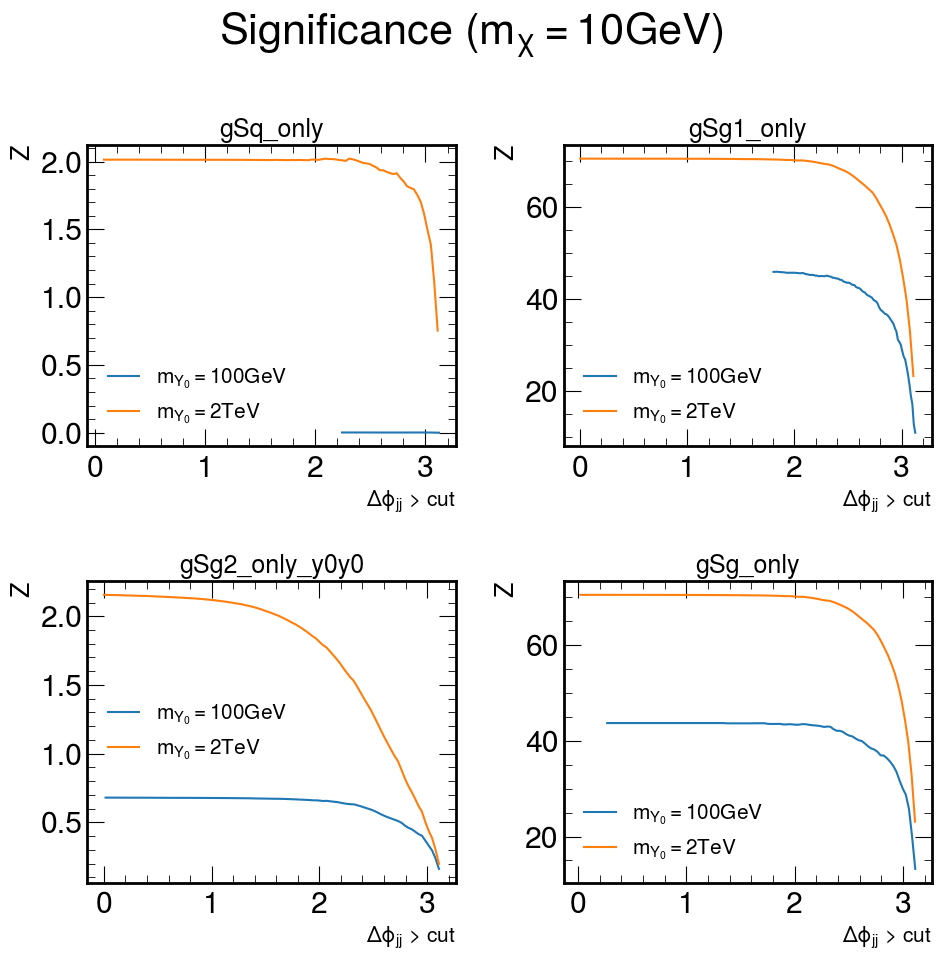

In [50]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\Delta\phi_{jj}$ > cut",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

### $m_{jj}$

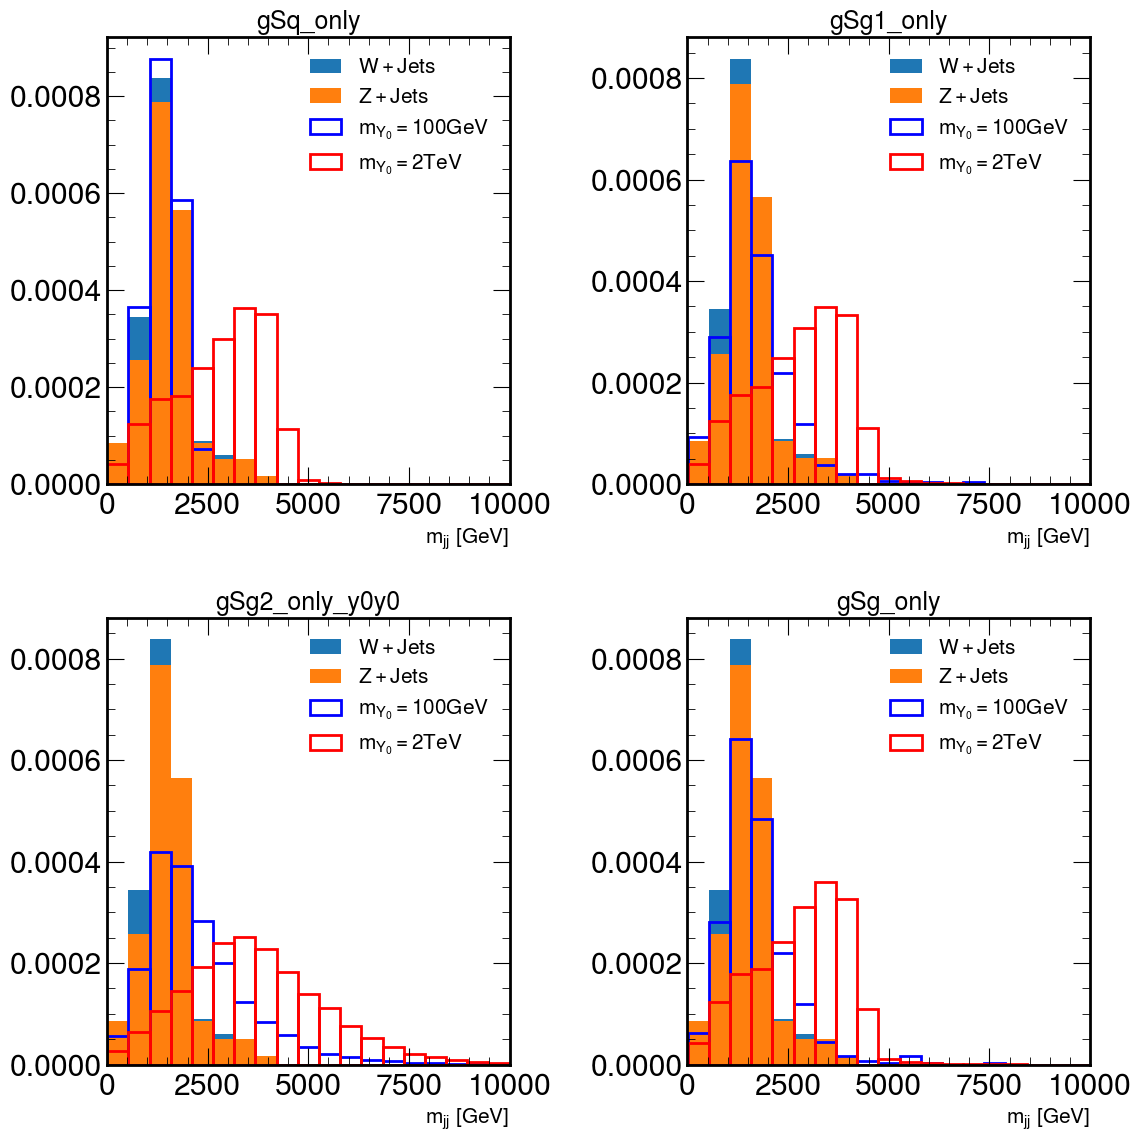

In [51]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Inv_mass', r"$m_{jj}$ [GeV]", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,10000))

In [52]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='Inv_mass', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:349: RuntimeWarning: invalid value encountered in scalar divide
  Z[i][j][k] = S / np.sqrt(S + B)


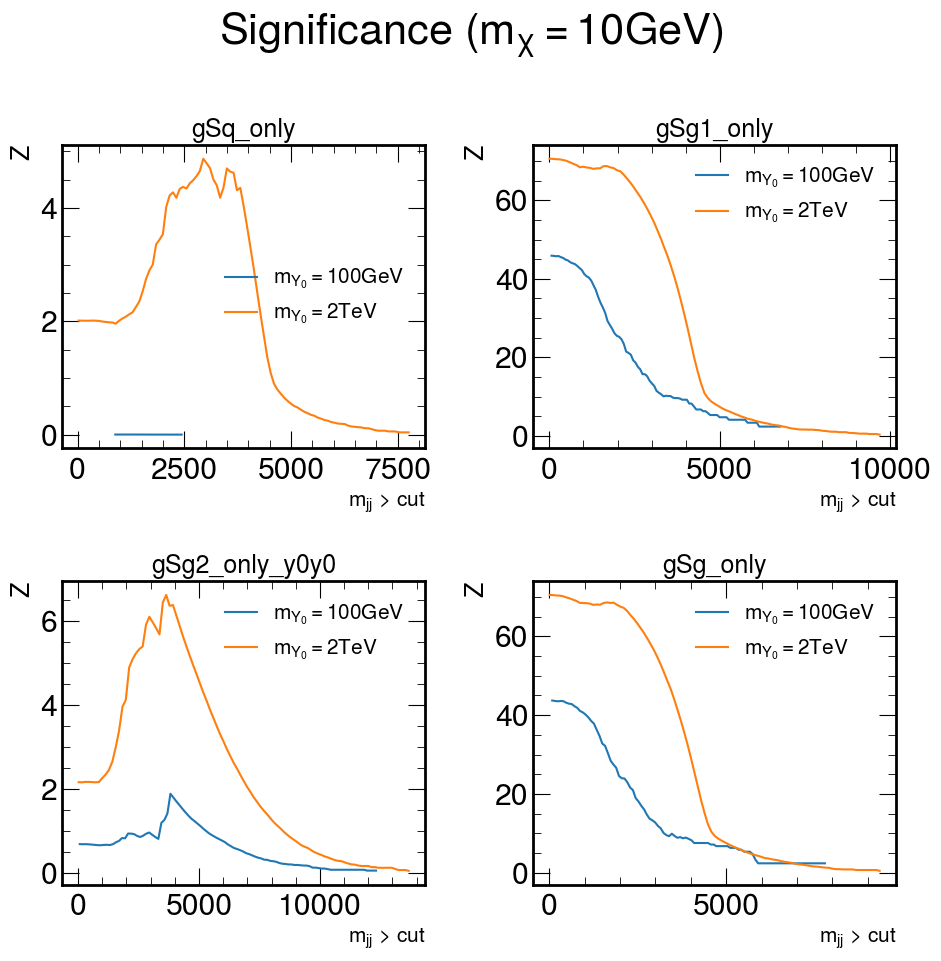

In [53]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$m_{jj}$ > cut",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

### $\Delta \eta_{jj}$

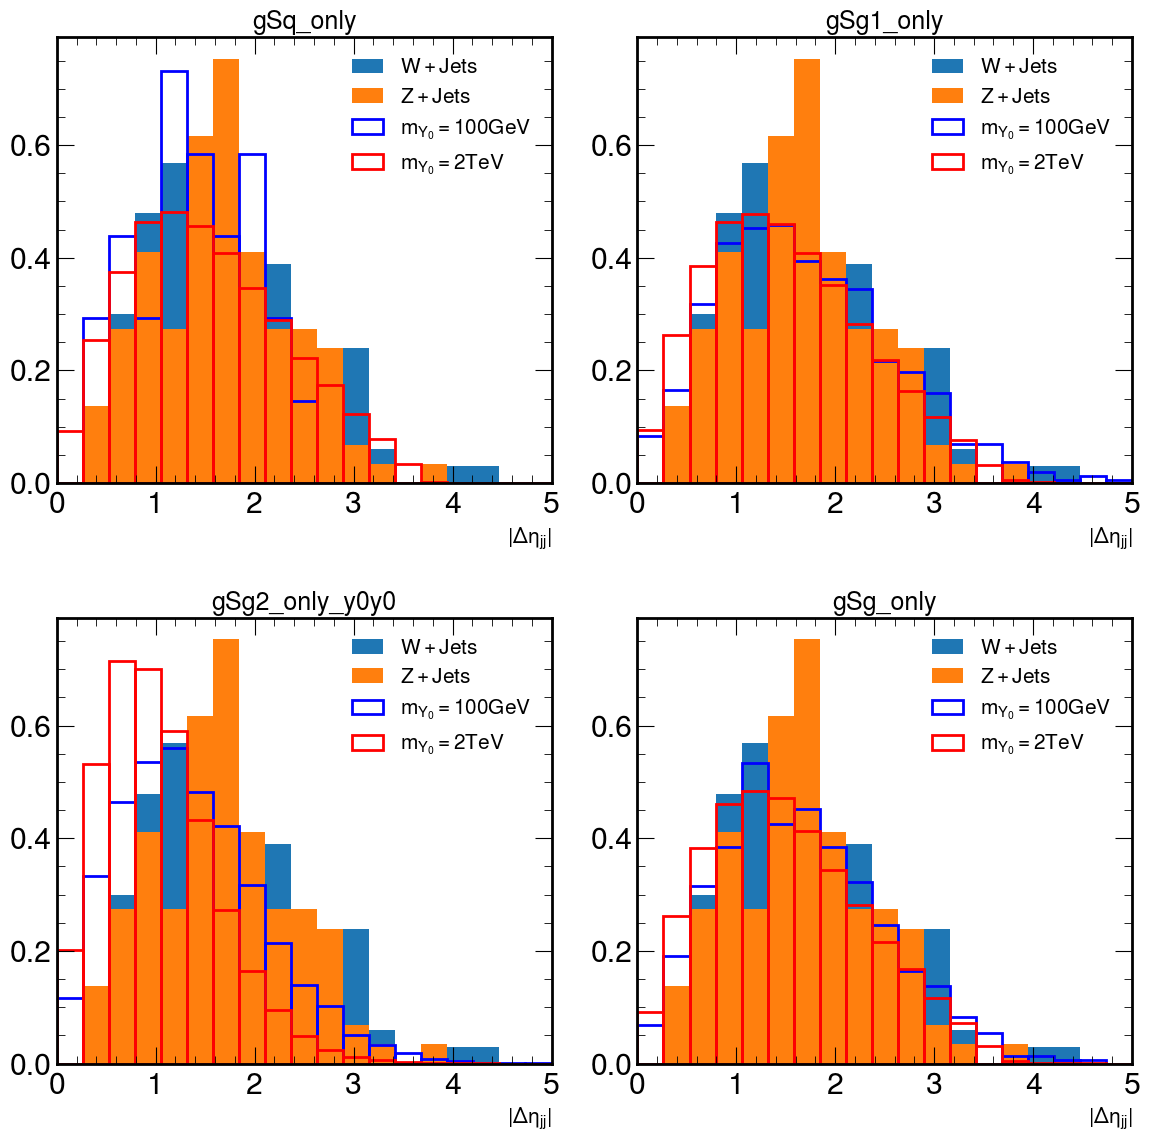

In [54]:
plot_4cases([data_WpJ, data_ZpJ], data, cases, 'Delta_rapidity', r"$|\Delta\eta_{jj}|$", [r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"], xlim=(0,5))

In [55]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='Delta_rapidity', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:349: RuntimeWarning: invalid value encountered in scalar divide
  Z[i][j][k] = S / np.sqrt(S + B)


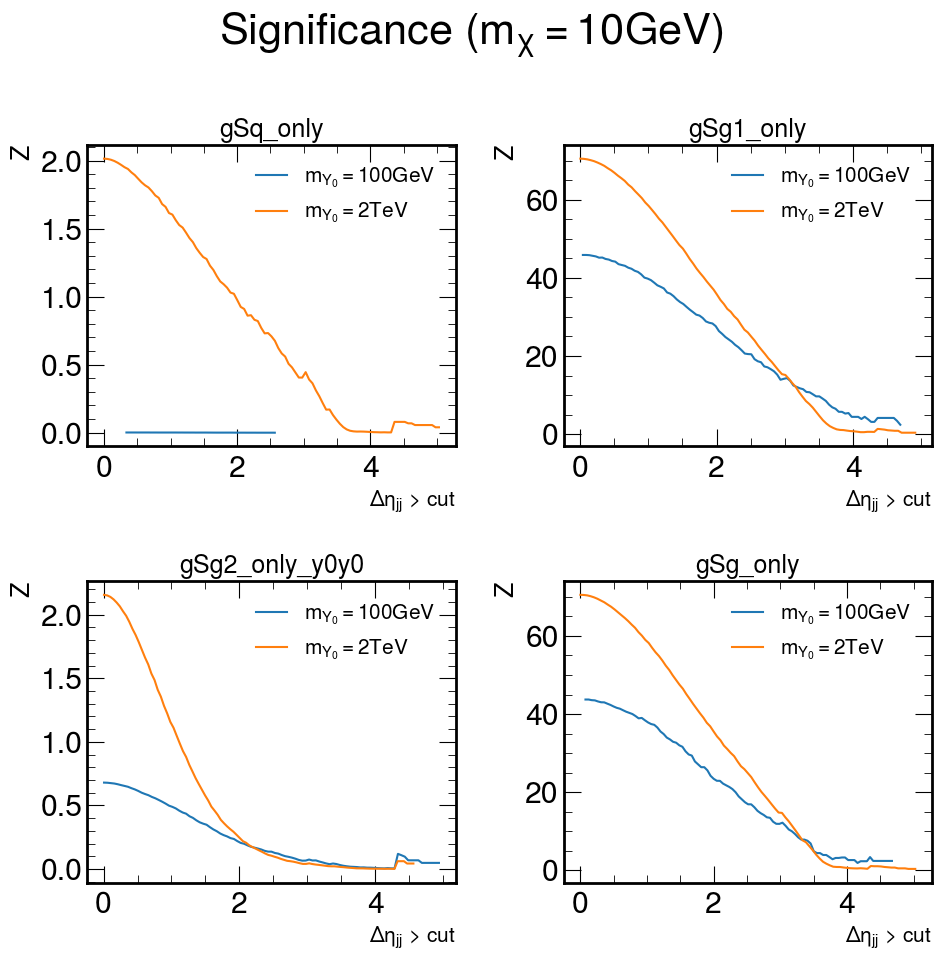

In [56]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\Delta\eta_{jj}$ > cut",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()